In [ ]:
import os
os.system('pip install -U git+https://github.com/albumentations-team/albumentations')

from functools import wraps, reduce

import PIL, cv2, sklearn, sys, json, math

from tqdm.notebook import tqdm
from glob import glob
from PIL import Image, ImageEnhance, ImageDraw, ImageFilter
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb
import matplotlib.pyplot as plt

import albumentations as albu
import numpy as np
import time, shutil, datetime
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

#### Initial Dataset Processing

In [ ]:
if not os.path.exists('./review_object_detection_metrics'):
    os.system("git clone https://github.com/rafaelpadilla/review_object_detection_metrics.git")
    os.system("python3 ./review_object_detection_metrics/setup.py install")
    os.system("pip3 install PyQt5")
    os.system("cp -R ./review_object_detection_metrics/src ./src")
 
import shutil
from src.bounding_box import BoundingBox
from src.utils import converter
from src.bounding_box import BoundingBox
from src.utils.enumerators import (BBFormat, BBType, CoordinatesType,
                                   MethodAveragePrecision)
import src.evaluators.coco_evaluator as coco_evaluator
import src.evaluators.pascal_voc_evaluator as pascal_voc_evaluator

In [ ]:
input_shape = (416, 416)
max_boxes = 150

In [ ]:
def str_write_annots(annots):
    cnt, max_bboxes = 0, 0
    ret_str = ''
 
    for annot in annots:
        if not os.path.exists(annot[0]):
            print('Missing', annot[0])
            continue
        if len(annot[1:]) == 0:
            continue
 
        tmp_line = [annot[0]]
 
        for ann in annot[1:]:
            tmp_line.append(','.join(ann))
 
        max_bboxes = max(max_bboxes, len(annot)-1)
        cnt += 1
        ret_str += ' '.join(tmp_line) + '\n'
    
    print('String of', cnt, 'lines')
    print(max_bboxes, 'bboxes found')
    return ret_str

def deep_fruits_reader(bucket_pick=None, verbose=True):
    if not os.path.exists('./DeepFruits'):
        print('Copying')
        os.system("cp './datasets/deepFruits_dataset.zip' './DeepFruits.zip' ")
        print('Unzipping')
        os.makedirs('./DeepFruits')
        os.system("unzip -qq './DeepFruits.zip' -d './DeepFruits'")
 
    text_files = sorted(glob('./DeepFruits/*/*/*/*.txt', recursive=True))
    label = ['apple', 'avocado', 'mango', 'orange', 'rockmelon', 'strawberry']
    annots, label_counts, is_train = [], [], []
 
    for text_file in text_files:
        if ('index' in text_file) or ('readme' in text_file) or ('caps' in text_file):
            continue
        with open(text_file, 'r') as f:
            for line in f.readlines():
                data = line.split()
                filename = data[0]
                counts = int(data[1])
                data = data[2:]
                tmp = (os.path.sep).join(text_file.split(os.path.sep)[:-1])
                tmp = os.path.join(tmp, filename)
 
                tmp_annot_bbox = []
 
                for i in range(0, len(data), 6):
                    x_min, y_min, x_max, y_max = data[i], data[i+1], data[i+2], data[i+3]
                    target = text_file.split(os.path.sep)[-2]
                    tmp_annot_bbox.append([x_min, y_min, x_max, y_max, 
                                           str(label.index(target))])
                is_train.append('train' in text_file)
                annots.append([tmp] + tmp_annot_bbox)
 
    annots = np.array(annots)
    is_train = np.array(is_train)
    print(f'Train: {len(np.where(is_train == True)[0])}, Test: {len(np.where(is_train == False)[0])}')
 
 
    print('Writing train data')
    if bucket_pick is not None:
        new_annots, label_bucket = [], [[] for i in range(len(label))]
        for x in annots[:train]:
            label_bucket[int(x[-1][-1])].append(x)
            #print(int(x[-1][-1]), x)
 
        for i in range(len(label)):
            label_bbox_cnt = 0
            while label_bbox_cnt < bucket_pick:
                id = np.random.randint(0, len(label_bucket[i]))
                label_bbox_cnt += len(label_bucket[i][id]) - 1
                new_annots.append(label_bucket[i][id])
        
        with open('DeepFruits_train.txt', 'w') as f:
            f.write(str_write_annots(new_annots))
 
    else:
        with open('DeepFruits_train.txt', 'w') as f:
            f.write(str_write_annots(annots[is_train]))
    
    print('Writing test data')
    with open('DeepFruits_test.txt', 'w') as f:
        f.write(str_write_annots(annots[~is_train]))
 
    return label


def mango_yolo_reader():
    import xml.etree.ElementTree as ET

    def read_content(xml_file: str):

        tree = ET.parse(xml_file)
        root = tree.getroot()

        list_with_all_boxes = []

        for boxes in root.iter('object'):

            filename = root.find('filename').text

            ymin, xmin, ymax, xmax = None, None, None, None

            ymin = boxes.find("bndbox/ymin").text
            xmin = boxes.find("bndbox/xmin").text
            ymax = boxes.find("bndbox/ymax").text
            xmax = boxes.find("bndbox/xmax").text

            list_with_single_boxes = [xmin, ymin, xmax, ymax, '0']
            list_with_all_boxes.append(list_with_single_boxes)

        return list_with_all_boxes

    if not os.path.exists('./mangoYOLO'):
        print('Copying')
        os.system("cp './datasets/mangoYOLO.zip' './mangoYOLO.zip'")
        print('Unzipping')
        os.makedirs('./mangoYOLO')
        os.system("unzip -qq './mangoYOLO.zip' -d './mangoYOLO'")

    annot_files = sorted(glob('./mangoYOLO/**/*.xml', recursive=True))
    img_files = sorted(glob('./mangoYOLO/**/*.jpg', recursive=True))
    tst_file_names = glob('./mangoYOLO/**/test.txt', recursive=True)[0]
    with open(tst_file_names, 'r') as f:
        tst_file_names = []
        for s in f.readlines():
            tst_file_names.append(s.strip())
    
    annots = []
    is_test = []

    #print(tst_file_names)

    for f, a in zip(img_files, annot_files):
        bxs = read_content(a)
        annots.append([f] + bxs)
        fname = os.path.splitext(os.path.basename(f))[0]
        #print(fname)
        is_test.append(fname in tst_file_names)
    
    is_test = np.array(is_test)
    annots = np.array(annots)
    
    print(f'Train: {len(np.where(is_test == False)[0])}, Test: {len(np.where(is_test == True)[0])}')

    with open('mangoYOLO_train.txt', 'w') as f:
        f.write(str_write_annots(annots[~is_test]))
    
    print('Writing test data')
    with open('mangoYOLO_test.txt', 'w') as f:
        f.write(str_write_annots(annots[is_test]))

    return ['mango']


def multi_fruits_reader(verbose=True):
    if not os.path.exists('./MultiFruit'):
        print('Copying')
        os.system("cp './datasets/acfr-multifruit-2016.zip' './acfr-multifruit.zip'")
        print('Unzipping')
        os.makedirs('./MultiFruit')
        os.system("unzip -qq './acfr-multifruit.zip' -d './MultiFruit'")
        
    csv_files = sorted(glob('./MultiFruit/*/*/*/*.csv', recursive=True))
    img_files = sorted([f for f in glob('./MultiFruit/*/*/*/*.png', recursive=True) if 'segmentations' not in f])
    
    tst_file_names = glob('./MultiFruit/**/test.txt', recursive=True)
    tst_imgs = []
    for f in tst_file_names:
        with open(f, 'r') as f:
            for s in f.readlines():
                tst_imgs.append(s.strip())

    trn_file_names = glob('./MultiFruit/**/train_val.txt', recursive=True)
    trn_imgs = []
    for f in trn_file_names:
        with open(f, 'r') as f:
            for s in f.readlines():
                trn_imgs.append(s.strip())
    
    label = ['almonds', 'apples', 'mangoes']
    annots, label_counts = [], []
    is_train, is_test = [], []

    print(len(csv_files), len(img_files), len(tst_imgs), len(trn_imgs))

    for csvf, imgf in zip(csv_files, img_files):
        tmp = []
        data_label = csvf.split(os.path.sep)[-3]
        w, h = Image.open(imgf).size
        fname = os.path.basename(imgf)
        fname = '.'.join(fname.split('.')[:-1])
        #print(data_label)

        with open(csvf, 'r') as f:
            for l in f.readlines()[1:]:
                if len(l) == 0: continue
                
                point = list(map(float, l.split(',')[1:-1]))
                #if len(point) != 4: continue

                x_min, y_min, x_max, y_max = 0, 0, 0, 0
                if data_label == 'apples':
                    # Need to convert circle to bbox
                    x_min = max(int(point[0] - point[2]), 0)
                    y_min = max(int(point[1] - point[2]), 0)
                    x_max = min(int(point[0] + point[2]), w)
                    y_max = min(int(point[1] + point[2]), h)
                else:
                    # bbox are given in format x_min, y_min, dx, dy
                    x_min = max(int(point[0]), 0)
                    y_min = max(int(point[1]), 0)
                    x_max = min(int(point[0] + point[2]), w)
                    y_max = min(int(point[1] + point[3]), h)
                
                tmp.append([str(x_min), str(y_min), str(x_max), str(y_max),
                            str(label.index(data_label))])

        annots.append([imgf] + tmp)
        is_test.append(fname in tst_imgs)
        is_train.append(fname in trn_imgs)
    
    annots = np.array(annots)
    is_test = np.array(is_test, dtype=np.bool)
    is_train = np.array(is_train, dtype=np.bool)
    total = len(annots)
    print(f'Train: {len(is_train)}, Test: {len(is_test)}')#, Val: {val}')

    print('Writing train data')
    with open('MultiFruit_train.txt', 'w') as f:
        f.write(str_write_annots(annots[is_train]))
    
    print('Writing test data')
    with open('MultiFruit_test.txt', 'w') as f:
        f.write(str_write_annots(annots[is_test]))

    return ['almond', 'apple', 'mango']


def coco_reader(verbose=True, version='2017'):
    assert version in ['2017', '2014']
    if not os.path.exists(f'./coco'):
        print('Copying')
        os.system(f"cp './datasets/coco/cocoAnnotsTrainVal{version}.zip' './cocoAnnotsTrainVal{version}.zip'")
        os.system(f"cp './datasets/coco/cocoVal{version}.zip' './cocoVal{version}.zip'")
        print('Unzipping')
        os.makedirs(f'./coco{version}/')
        os.system(f"unzip -qq './cocoAnnotsTrainVal{version}.zip' -d './coco/'")
        os.system(f"unzip -qq './datasets/coco/cocoVal{version}.zip' -d './coco/'")
 

    data = glob(f'./coco/val{version}/*.jpg*')
    print(len(data), 'images found')

    with open (f'./coco/annotations/instances_val{version}.json', 'r') as f:
        js = json.load(f)
    print(len(js['annotations']), 'annotations found')

    annot_pos = dict()
    id_to_file = dict()
    annots = []

    for d in data:
        base_id = int(os.path.basename(d).split('.')[0])
        id_to_file[base_id] = d

    labels = []
    id_to_labels = dict()
    for c in js['categories']:
        id_to_labels[int(c['id'])] = c['name']
        labels.append(c['name'])
    labels = sorted(labels)

    print(len(id_to_file))

    for i in range(len(js['annotations'])):
        bbox = js['annotations'][i]['bbox']
        annot_id = int(js['annotations'][i]['category_id'])
        img_id = js['annotations'][i]['image_id']

        if len(bbox) == 0:
            continue

        bbox[2] += bbox[0]
        bbox[3] += bbox[1]
        bbox = list(map(int, bbox))
        bbox = list(map(str, bbox))
        bbox.append(str(labels.index(id_to_labels[annot_id])))

        if img_id not in annot_pos:
            annot_pos[img_id] = []
        annot_pos[img_id].append(bbox)
    
    #print(annot_pos[list(annot_pos.keys())[0]])

    for k, v in annot_pos.items():
        annots.append([id_to_file[k]] + v)

    #print(annots[0])

    annots = sklearn.utils.shuffle(annots, random_state=12)
    total = len(annots)
    test = int(total*0.05)
    train = total - test
    
    print(f'Train: {train}, Test: {test}')

    with open(f'coco{version}_train.txt', 'w') as f:
        f.write(str_write_annots(annots[:train]))
    
    print('Writing test data')
    with open(f'coco{version}_test.txt', 'w') as f:
        f.write(str_write_annots(annots[train:]))

    return labels


def minne_apple_reader(verbose=True):
    """
    Inherited from:
    https://github.com/nicolaihaeni/MinneApple/blob/master/data/apple_dataset.py
    """
    if not os.path.exists('./MinneApple'):
        print('Copying')
        os.system("cp './datasets/MinneApple.tar.gz' './MinneApple.tar.gz' ")
        print('Unzipping')
        os.makedirs('./MinneApple')
        os.system("tar xf './MinneApple.tar.gz' -C './MinneApple'")
    
    # Load all image and mask files, sorting them to ensure they are aligned
    imgs = glob('./MinneApple/detection/train/images/*png', recursive=True)
    masks = glob('./MinneApple/detection/train/masks/*png', recursive=True)
    annots = []
    
    for img_path, mask_path in tqdm(zip(imgs, masks)):
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        # Convert the PIL image to np array
        mask = np.array(mask)
        obj_ids = np.unique(mask)

        masks = mask == obj_ids[:, None, None]
        num_objs = len(obj_ids)
        boxes = []
        h, w = mask.shape

        for ii in range(num_objs):
            pos = np.where(masks[ii])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])

            if xmin == xmax or ymin == ymax: continue

            xmin = np.clip(xmin, a_min=0, a_max=w)
            xmax = np.clip(xmax, a_min=0, a_max=w)
            ymin = np.clip(ymin, a_min=0, a_max=h)
            ymax = np.clip(ymax, a_min=0, a_max=h)

            if xmin == 0 and xmax == w: continue
            if ymin == 0 and ymax == h: continue

            area = (xmax - xmin) * (ymax - ymin)
            if area > w*h*0.7: continue

            boxes.append([str(xmin), str(ymin), str(xmax), str(ymax), "0"])
        
        annots.append([img_path] + boxes)

    annots = sklearn.utils.shuffle(annots, random_state=12)
    total = len(annots)
    test = int(total*0.15)
    train = total - test
    
    print(f'Train: {train}, Test: {test}')

    with open(f'MinneApple_train.txt', 'w') as f:
        f.write(str_write_annots(annots[:train]))
    
    print('Writing test data')
    with open(f'MinneApple_test.txt', 'w') as f:
        f.write(str_write_annots(annots[train:]))

    return ["apple"]


def grape_reader(verbose=True):
    """
    Inherited from:
    https://github.com/thsant/wgisd/blob/1.0.0/WGISD.ipynb
    """
    if not os.path.exists('./wgisd'):
        print('Copying')
        os.system("cp './datasets/wgisd-1.0.0.zip' './wgisd-1.0.0.zip' ")
        print('Unzipping')
        os.makedirs('./wgisd')
        os.system("unzip -qq './wgisd-1.0.0.zip' -d './wgisd'")

    # Load all image and mask files, sorting them to ensure they are aligned
    imgs = sorted(glob('./wgisd/thsant-wgisd-ab223e5/data/*.jpg', recursive=True))
    masks = sorted(glob('./wgisd/thsant-wgisd-ab223e5/data/*.txt', recursive=True))
    annots = []
    labels = ['CDY', 'CFR', 'CSV', 'SVB', 'SYH']
    
    in_train = set()
    with open('./wgisd/thsant-wgisd-ab223e5/train.txt', 'r') as f:
        for line in f.readlines():
            in_train.add(line.strip())

    #print(len(imgs), len(masks), print(in_train))

    is_train = []
    for img_path, obj_path in zip(imgs, masks):
        img = Image.open(img_path)
        boxes = []
        cls = os.path.basename(img_path).split('_')[0]
        fname = os.path.basename(img_path).split('.')[0]

        with open(obj_path, 'r') as f:
            for line in f.readlines():
                data = list(map(float, line.strip().split()[1:]))

                x_center = data[0]
                y_center = data[1]

                xmin = (x_center-data[2]/2.0) * img.size[0]
                xmax = (x_center+data[2]/2.0) * img.size[0]
                ymin = (y_center-data[3]/2.0) * img.size[1]
                ymax = (y_center+data[3]/2.0) * img.size[1]
                
                if xmin == xmax:
                    if xmin > 0: xmin -= 1
                    else: xmax += 1
                if ymin == ymax:
                    if ymin > 0: ymin -= 1
                    else: ymax += 1

                xmin = max(xmin, 0)
                ymin = max(ymin, 0)
                xmax = min(xmax, img.size[0])
                ymax = min(ymax, img.size[1])

                boxes.append([str(int(xmin)), str(int(ymin)), 
                              str(int(xmax)), str(int(ymax)), 
                              str(labels.index(cls))])
        
        annots.append([img_path] + boxes)
        is_train.append(fname in in_train)

    annots = np.array(annots)
    is_train = np.array(is_train, dtype=np.bool)
    is_test = ~is_train
    tot_train = np.bincount(is_train)[1]
    tot_test = np.bincount(is_test)[1]
    total = len(annots)

    print(f'Train: {tot_train}, Test: {tot_test}')#, Val: {val}')

    print('Writing train data')
    with open('wgisd_train.txt', 'w') as f:
        f.write(str_write_annots(annots[is_train]))
    
    print('Writing test data')
    with open('wgisd_test.txt', 'w') as f:
        f.write(str_write_annots(annots[is_test]))

    return labels


def extract_dataset(data_index):
    dataset = ['DeepFruits', 'mangoYOLO', 'MultiFruit', 'MinneApple', 'wgisd', 'coco2017']
    print(f'Selecting {dataset[data_index]}')

    annot_label = None
    if data_index == 0:
        annot_label = deep_fruits_reader()
    elif data_index == 1:
        annot_label = mango_yolo_reader()
    elif data_index == 2:
        annot_label = multi_fruits_reader()
    elif data_index == 3:
        annot_label = minne_apple_reader()
    elif data_index == 4:
        annot_label = grape_reader()
    elif data_index == 5:
        annot_label = coco_reader()

    with open(f'./{dataset[data_index]}_train.txt', 'r') as f:
        train_lines = [l for l in f.readlines()]

    with open(f'./{dataset[data_index]}_test.txt', 'r') as f:
        test_lines = [l for l in f.readlines()]

    #with open(f'./{dataset[data_index]}_val.txt', 'r') as f:
    #    val_lines = [l for l in f.readlines()]

    return train_lines, test_lines, annot_label

### A Basic YOLO-v3 Implementation

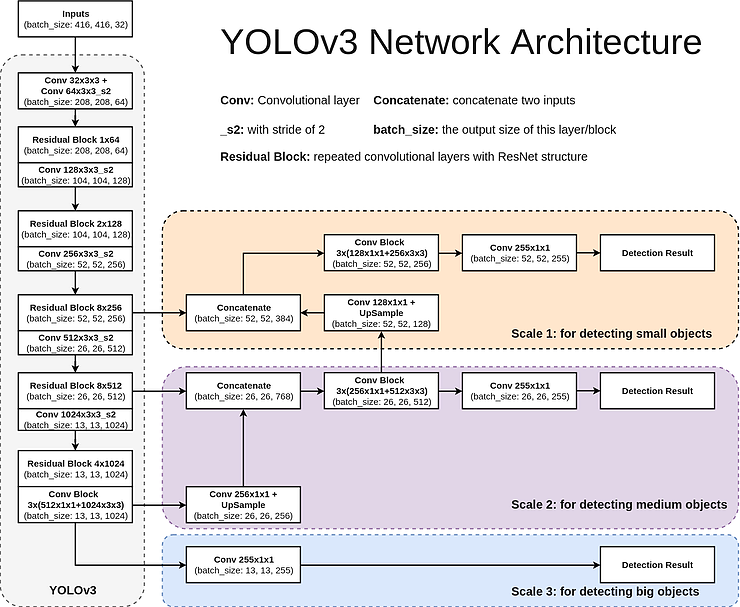

In [ ]:
# The basic building blocks
from functools import reduce

def compose(*funcs):
    """Compose arbitrarily many functions, evaluated left to right.
    Reference: https://mathieularose.com/function-composition-in-python/
    """
    # return lambda x: reduce(lambda v, f: f(v), funcs, x)
    if funcs:
        return reduce(lambda f, g: lambda *a, **kw: g(f(*a, **kw)), funcs)
    else:
        raise ValueError('Composition of empty sequence not supported.')

#@wraps(Conv2D)
def DarknetConv2D(*args, **kwargs):
	"""Wrapper to set Darknet parameters for Convolution2D."""
	darknet_conv_kwargs = dict(kernel_regularizer=l2(5e-4))
	darknet_conv_kwargs['padding'] = 'valid' if kwargs.get('strides') == (2, 2) else 'same'
	darknet_conv_kwargs.update(kwargs)
	return Conv2D(*args, **darknet_conv_kwargs)


def DarknetConv2D_BN_Leaky(*args, **kwargs):
    """Darknet Convolution2D followed by BatchNormalization and LeakyReLU."""
    no_bias_kwargs = {'use_bias': True}
    drop = kwargs['dropout']
    if 'dropout' in kwargs: del kwargs['dropout']
    no_bias_kwargs.update(kwargs)

    if drop != None and drop > 0:
        return compose(DarknetConv2D(*args, **no_bias_kwargs),
                       SpatialDropout2D(drop),
                       BatchNormalization(),
                       LeakyReLU(alpha=0.1))
    else:
        return compose(DarknetConv2D(*args, **no_bias_kwargs),
                       BatchNormalization(),
                       LeakyReLU(alpha=0.1))

def YOLOv3(inputs, num_anchors, num_classes, **kwargs):
    """Create YOLO_V3 model CNN body in Keras."""

    def make_last_layers(x, num_filters, out_filters):
        """6 Conv2D_BN_Leaky layers followed by a Conv2D_linear layer"""
        x = compose(
                DarknetConv2D_BN_Leaky(num_filters, (1,1), **kwargs),
                DarknetConv2D_BN_Leaky(num_filters*2, (3,3), **kwargs),
                DarknetConv2D_BN_Leaky(num_filters, (1,1), **kwargs),
                DarknetConv2D_BN_Leaky(num_filters*2, (3,3), **kwargs),
                DarknetConv2D_BN_Leaky(num_filters, (1,1), **kwargs))(x)
        y = compose(
                DarknetConv2D_BN_Leaky(num_filters*2, (3,3), **kwargs),
                DarknetConv2D(out_filters, (1,1)))(x)
        return x, y

    def darknet53_body(x):
        """Darknent body having 52 Convolution2D layers"""
        x = DarknetConv2D_BN_Leaky(32, (3,3), **kwargs)(x)
        x = resblock_body(x, 64, 1)
        x = resblock_body(x, 128, 2)
        x = resblock_body(x, 256, 8)
        x = resblock_body(x, 512, 8)
        x = resblock_body(x, 1024, 4)
        return x

    def resblock_body(x, num_filters, num_blocks):
        """A series of resblocks starting with a downsampling Convolution2D"""
        # Darknet uses left and top padding instead of 'same' mode
        x = ZeroPadding2D(((1,0),(1,0)))(x)
        x = DarknetConv2D_BN_Leaky(num_filters, (3,3), strides=(2,2), **kwargs)(x)
        for i in range(num_blocks):
            y = compose(
                    DarknetConv2D_BN_Leaky(num_filters//2, (1,1), **kwargs),
                    DarknetConv2D_BN_Leaky(num_filters, (3,3), **kwargs))(x)
            x = Add()([x,y])
        return x

    darknet = Model(inputs, darknet53_body(inputs))
    x, y1 = make_last_layers(darknet.output, 512, num_anchors*(num_classes+5))

    x = compose(
            DarknetConv2D_BN_Leaky(256, (1,1), **kwargs),
            UpSampling2D(2))(x)
    x = Concatenate()([x,darknet.layers[152].output])
    x, y2 = make_last_layers(x, 256, num_anchors*(num_classes+5))

    x = compose(
            DarknetConv2D_BN_Leaky(128, (1,1), **kwargs),
            UpSampling2D(2))(x)
    x = Concatenate()([x,darknet.layers[92].output])
    x, y3 = make_last_layers(x, 128, num_anchors*(num_classes+5))

    return Model(inputs, [y1,y2,y3], name='YOLOv3')

### MangoYOLO Implementation

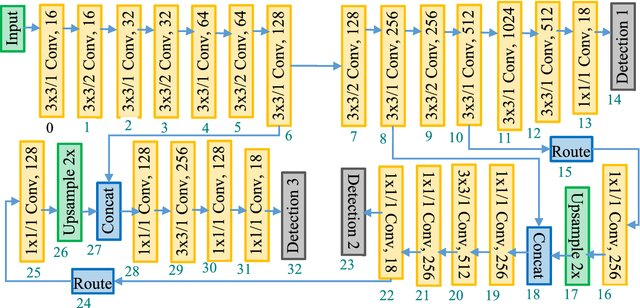

In [ ]:
def MangoYOLO(inputs, num_anchors, num_classes, **kwargs):
	"""Create Tiny YOLO_v3 model CNN body in keras."""
	x1 = compose(
		DarknetConv2D_BN_Leaky(16, (3,3), **kwargs),
		DarknetConv2D_BN_Leaky(16, (3, 3), strides=2, **kwargs),
		DarknetConv2D_BN_Leaky(32, (3,3), **kwargs),
		DarknetConv2D_BN_Leaky(32, (3, 3), strides=2, **kwargs),
		DarknetConv2D_BN_Leaky(64, (3,3), **kwargs),
		DarknetConv2D_BN_Leaky(64, (3, 3), strides=2, **kwargs),
		DarknetConv2D_BN_Leaky(128, (3,3), **kwargs))(inputs)
	x2 = compose(
		DarknetConv2D_BN_Leaky(128, (3, 3), strides=2, **kwargs),
		DarknetConv2D_BN_Leaky(256, (3, 3), **kwargs),
	)(x1)
	x3 = compose(
		DarknetConv2D_BN_Leaky(256, (3, 3), strides=2, **kwargs),
		DarknetConv2D_BN_Leaky(512, (3, 3), **kwargs)
	)(x2)
	y1 = compose(
		DarknetConv2D_BN_Leaky(1024, (3, 3), **kwargs),
		DarknetConv2D_BN_Leaky(512, (3, 3), **kwargs),
		DarknetConv2D(num_anchors * (num_classes + 5), (1, 1), name="y1")
	)(x3)
	x4 = compose(
		DarknetConv2D_BN_Leaky(256, (1,1), **kwargs),
		UpSampling2D(2)
	)(x3)
	y2 = compose(
		Concatenate(),
		DarknetConv2D_BN_Leaky(256, (1,1), **kwargs),
		DarknetConv2D_BN_Leaky(512, (3, 3), **kwargs),
		DarknetConv2D_BN_Leaky(256, (1, 1), **kwargs),
		DarknetConv2D(num_anchors*(num_classes+5), (1,1), name="y2")
	)([x2, x4])
	x5 = compose(
		DarknetConv2D_BN_Leaky(128, (1, 1), **kwargs),
		UpSampling2D(2)
	)(y2)
	y3 = compose(
		Concatenate(),
		DarknetConv2D_BN_Leaky(128, (1, 1), **kwargs),
		DarknetConv2D_BN_Leaky(256, (3, 3), **kwargs),
		DarknetConv2D_BN_Leaky(128, (1, 1), **kwargs),
		DarknetConv2D(num_anchors * (num_classes + 5), (1, 1), name="y3")
	)([x5, x1])
 
	return Model(inputs, [y1, y2, y3], name="MangoYOLO")

### A Basic YOLO-v4 Implementation

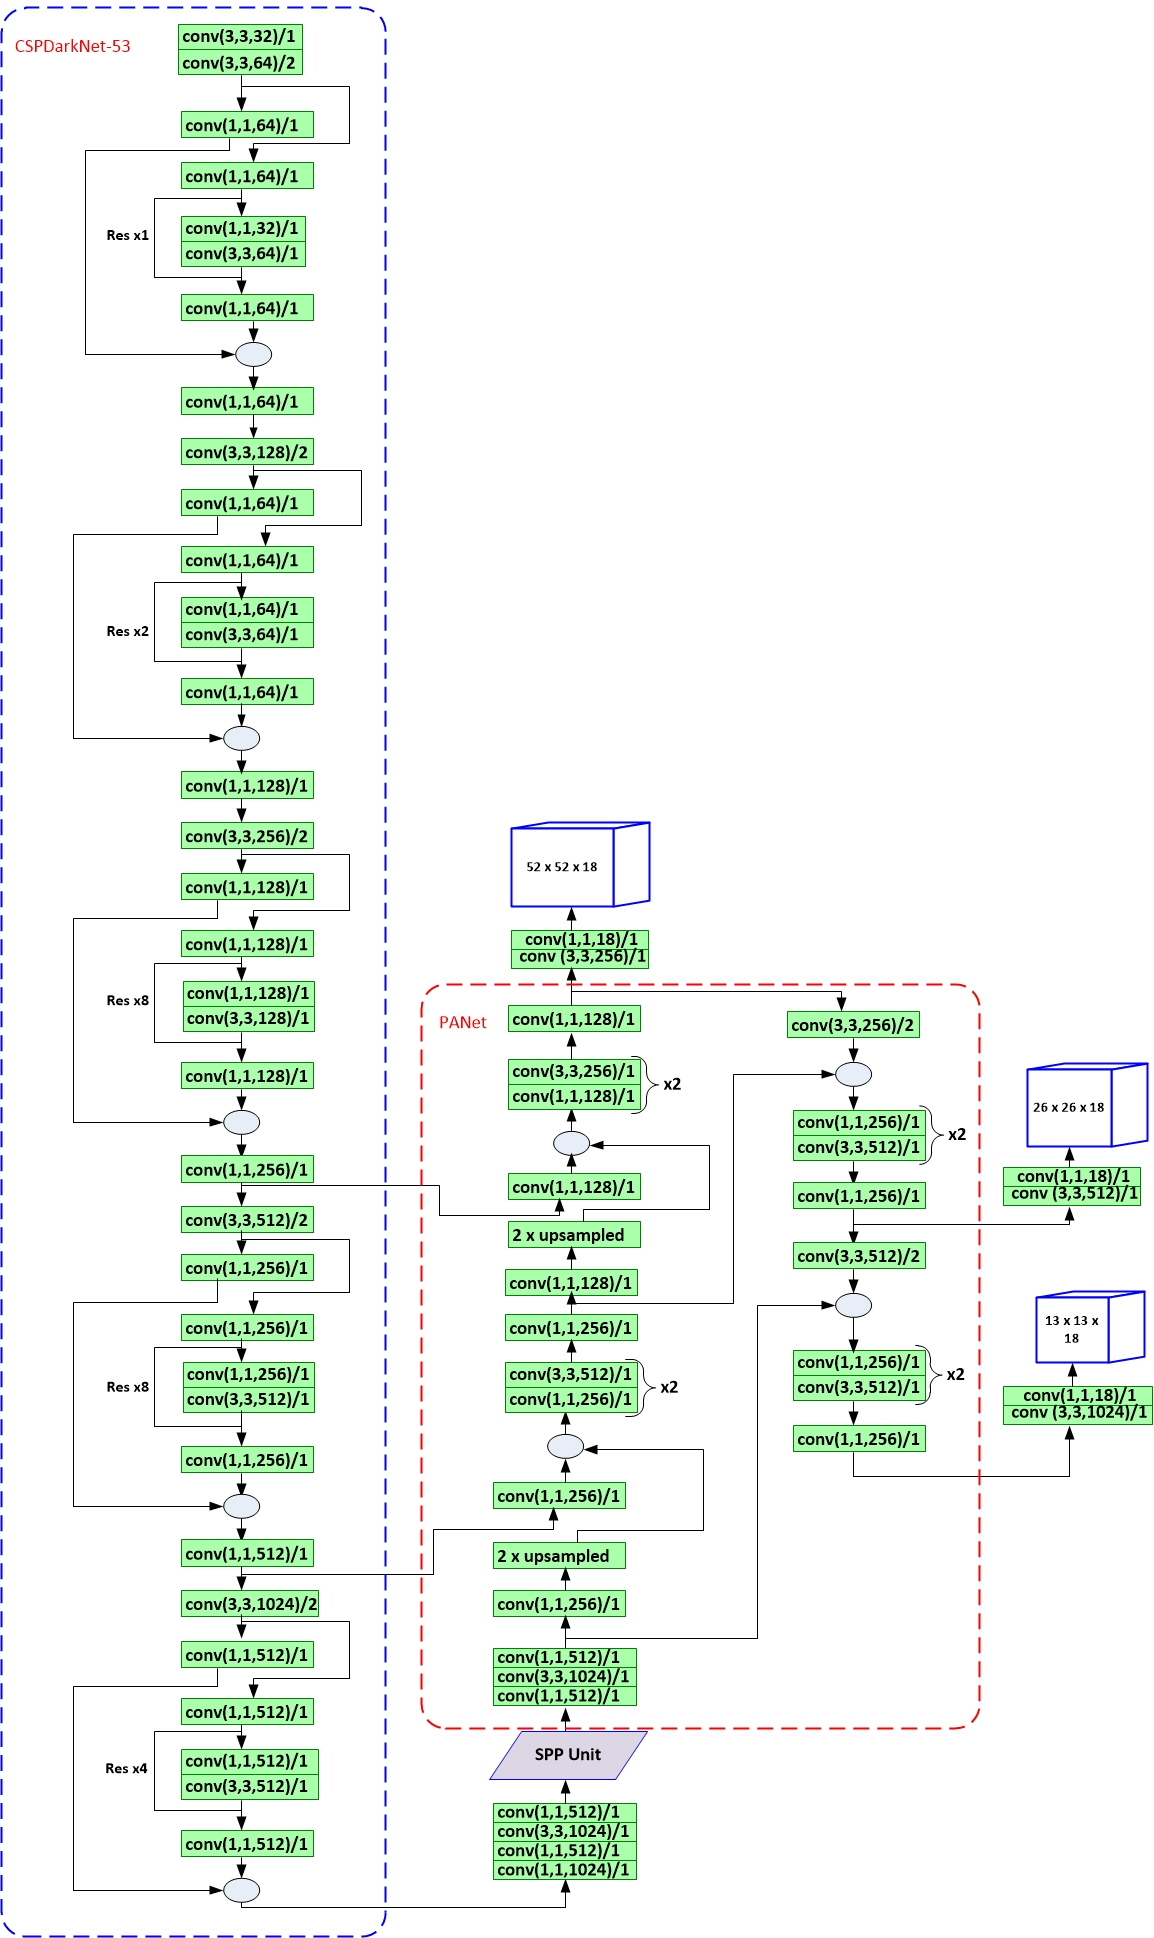

In [ ]:
def Darknet_CBA(*args, **kwargs):
    """Darknet Convolution2D followed by BatchNormalization and Mish"""
    no_bias_kwargs = {'use_bias': True}
    drop = kwargs.get('dropout')
    if 'dropout' in kwargs: del kwargs['dropout']
    no_bias_kwargs.update(kwargs)

    if drop != None and drop > 0:
        return compose(
            DarknetConv2D(*args, **no_bias_kwargs),
            SpatialDropout2D(drop),
            BatchNormalization(),
            Lambda(lambda x: x*tf.math.tanh(tf.math.softplus(x)))
            )
    else:
        return compose(
            DarknetConv2D(*args, **no_bias_kwargs),
            BatchNormalization(),
            Lambda(lambda x: x*tf.math.tanh(tf.math.softplus(x)))
            )


class SPP(tf.keras.layers.Layer):
    def __init__(self, bins, *args, **kwargs):
        self.bins = bins
        self.pool_layers = []

        super().__init__(*args, **kwargs)
    
    def build(self, input_shape):
        for b in self.bins:
            self.pool_layers.append(tf.keras.layers.MaxPooling2D(b, strides=1, padding="same"))

    def call(self, inputs, **kwargs):
        outputs = []
        for i in range(len(self.bins)):
            outputs.append(self.pool_layers[i](inputs))

        return tf.concat(outputs, axis=-1)


def YOLOv4(inputs, num_anchors, num_classes, **kwargs):
    """Create YOLO_V3 model CNN body in Keras."""
    
    def make_last_layers(x, num_filters, out_filters, name):
        """6 Conv2D_BN_Leaky layers followed by a Conv2D_linear layer"""
        x = compose(
                Darknet_CBA(num_filters, (1,1), **kwargs),
                Darknet_CBA(num_filters*2, (3,3), **kwargs),
                Darknet_CBA(num_filters, (1,1), **kwargs),
                Darknet_CBA(num_filters*2, (3,3), **kwargs))(x)

        x_sam = Darknet_CBA(num_filters*2, (3,3), **kwargs)(x)
        x_sam = tf.math.sigmoid(x_sam)
        x = Multiply(name=f"{name}_sam_mul")([x_sam, x])
        x = Darknet_CBA(num_filters, (1,1), **kwargs)(x)

        y = compose(
                Darknet_CBA(num_filters*2, (3,3), **kwargs),
                DarknetConv2D(out_filters, (1,1), name=name))(x)
        return x, y

    def csp_darknet53_body(x):
        """Darknent body having 52 Convolution2D layers"""
        name_list = []
        x = Darknet_CBA(32, (3,3), **kwargs)(x)
        name_list.append(x.name)
        x = csp_resblock_body(x, 64, 1)
        name_list.append(x.name.split('/')[0])
        x = csp_resblock_body(x, 128, 2)
        name_list.append(x.name.split('/')[0])
        x = csp_resblock_body(x, 256, 8)
        name_list.append(x.name.split('/')[0])
        x = csp_resblock_body(x, 512, 8)
        name_list.append(x.name.split('/')[0])
        x = csp_resblock_body(x, 1024, 4)
        return x, name_list

    def csp_resblock_body(x, num_filters, num_blocks):
        """A series of resblocks starting with a downsampling Convolution2D"""
        # Darknet uses left and top padding instead of 'same' mode
        x = ZeroPadding2D(((1,0),(1,0)))(x)
        x = Darknet_CBA(num_filters, (3,3), strides=(2,2), **kwargs)(x)

        x_csp, x = tf.split(x, 2, axis=-1)
        x_csp = Darknet_CBA(num_filters//2, (1,1), strides=(1,1), **kwargs)(x_csp)
        x = Darknet_CBA(num_filters//2, (1,1), strides=(1,1), **kwargs)(x)

        for i in range(num_blocks):
            y = compose(
                    Darknet_CBA(num_filters//4, (1,1), **kwargs),
                    Darknet_CBA(num_filters//2, (3,3), **kwargs))(x)
            x = Add()([x,y])
        
        x = Darknet_CBA(num_filters//2, (1,1), strides=(1,1), **kwargs)(x)
        x = Concatenate()([x_csp, x])
        return x

    backbone_out, layer_names = csp_darknet53_body(inputs)
    darknet = Model(inputs, backbone_out)
    x = darknet.output

    feats = 512

    x_spp = SPP([5, 9, 13])(x)
    x = Concatenate(name='SPP_concat')([x, x_spp])

    x = compose(Darknet_CBA(feats, (1,1), **kwargs),
                Darknet_CBA(feats*2, (3,3), **kwargs),
                Darknet_CBA(feats, (1,1), **kwargs))(x)

    y1_path = x

    x = compose(Darknet_CBA(256, (1,1), **kwargs),
                UpSampling2D(2))(x)

    out_26 = darknet.get_layer(layer_names[-1]).output
    out_26 = Darknet_CBA(256, (1,1), **kwargs)(out_26)
    x = Concatenate()([x, out_26])

    x = compose(Darknet_CBA(feats//2, (1,1), **kwargs),
                Darknet_CBA(feats, (3,3), **kwargs),
                Darknet_CBA(feats//2, (1,1), **kwargs),
                Darknet_CBA(feats, (3,3), **kwargs),
                Darknet_CBA(feats//2, (1,1), **kwargs))(x)

    y2_path = x

    x = compose(Darknet_CBA(128, (1,1), **kwargs),
                UpSampling2D(2))(x)

    out_52 = darknet.get_layer(layer_names[-2]).output
    out_52 = Darknet_CBA(128, (1,1), **kwargs)(out_52)
    y3_path = Concatenate()([x, out_52])
    
    x, y3 = make_last_layers(y3_path, 128, num_anchors*(num_classes+5), name="y3")
    
    x = Darknet_CBA(256, (3,3), strides=(2, 2), **kwargs)(x)
    x = ZeroPadding2D(((1,0),(1,0)))(x)

    y2_path = Concatenate()([y2_path, x])

    x, y2 = make_last_layers(y2_path, 256, num_anchors*(num_classes+5), name="y2")

    x = Darknet_CBA(256, (3,3), strides=(2, 2))(x)
    x = ZeroPadding2D(((1,0),(1,0)))(x)
    
    y1_path = Concatenate()([y1_path, x])

    x, y1 = make_last_layers(y1_path, 512, num_anchors*(num_classes+5), name="y1")

    return Model(inputs, [y1,y2,y3], name='YOLOv4')

### FruitDet Implementation

#### SPP, BlackOut, Attention

In [ ]:
class SpatialPyramidPooling2D(tf.keras.layers.Layer):
    def __init__(self, bins, attention=False, weight_decay=1E-4, 
                 activation='mish', *args, **kwargs):
        self.bins = bins
        self.pool_layers = []
        self.attention = attention
        if activation == 'mish':
            self.activation = Lambda(lambda x: x*tf.math.tanh(tf.math.softplus(x)))
        else:
            self.activation = tf.keras.layers.LeakyReLU(alpha=0.1)
        self.act_add = Lambda(lambda x: x[0] + x[0]*tf.keras.activations.sigmoid(x[1]))
        if self.attention:
            self.conv = []
            self.bn = []
            self.weight_decay = weight_decay
        super().__init__(*args, **kwargs)
    
    def build(self, input_shape):
        for b in self.bins:
            self.pool_layers.append(tf.keras.layers.MaxPooling2D(b, strides=1, padding="same"))
        if self.attention:
            for b in self.bins:
                self.conv.append(Conv2D(filters=input_shape[-1], kernel_size=(3,3),
                                        use_bias=True, #kernel_regularizer=l2(self.weight_decay),
                                        padding="same"))
                self.bn.append(BatchNormalization(axis=-1, gamma_regularizer=l2(self.weight_decay),
                                                  beta_regularizer=l2(self.weight_decay)))

    def call(self, inputs, **kwargs):
        outputs = []
        if self.attention:
            for i in range(len(self.bins)):
                outputs.append(self.bn[i](inputs))
                outputs[i] = self.activation(outputs[i])
                tmp = self.conv[i](outputs[i])
                outputs[i] = self.act_add([outputs[i], tmp])
                outputs[i] = self.pool_layers[i](outputs[i])
        else:
            for i in range(len(self.bins)):
                outputs.append(self.pool_layers[i](inputs))

        return tf.concat(outputs, axis=-1)
    

class Blackout(tf.keras.layers.Layer):
    _USE_V2_BEHAVIOR = True
 
    def __init__(self, rate=0.1, *args, **kwargs):
        self.rate = rate
        self.rate_log = tf.math.log([[self.rate, 1.-self.rate]])
        super(Blackout, self).__init__(*args, **kwargs)
 
    def random_hit(self):
        return tf.random.categorical(self.rate_log, 1)[0][0]
 
    def _get_training_value(self, training=None):
        if training is None:
            training = K.learning_phase()
        if self._USE_V2_BEHAVIOR:
            if isinstance(training, int):
                training = bool(training)
            if not self.trainable:
                # When the layer is not trainable, it overrides the value 
                # passed from model.
                training = False
        return training
 
    def call(self, inputs, training=None):
        if training is None:
            training = K.learning_phase()
        if training:
            return inputs * K.cast(self.random_hit(), dtype=K.dtype(inputs))
        return inputs


def dense_attention(x, name=None, drop=0.2, add=True, feats=None, weight_decay=1E-4,
              activation='mish', kernel=(1, 1)):
       #q = SeparableConv2D(x.shape[-1], (3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization(axis=-1, gamma_regularizer=l2(weight_decay),
                               beta_regularizer=l2(weight_decay))(x)
    #x = activation_func(activation)(x)
    x = ReLU()(x)
    q = Conv2D(x.shape[-1], kernel, strides=(1, 1), padding='same',
                  #kernel_regularizer=l2(weight_decay), 
                   use_bias=True)(x)
    q = tf.keras.activations.sigmoid(q)
    q = Lambda(lambda x: x[0] + x[0]*x[1])([x, q])
    return q

#### Model

In [ ]:
CONV_ID, BNORM_ID, DENSE_ID, ATT_ID = 0, 0, 0, 0

def FruitDet(input, output_channels, name, drop=0.2, return_body=False, **kwargs):
    '''FruitDet'''
    
    def activation_func(activation='mish'):
        act = None
        if activation == 'relu': act = ReLU()
        elif activation == 'leaky_relu': act = LeakyReLU(alpha=0.1)
        else: act = Lambda(lambda x: x*tf.math.tanh(tf.math.softplus(x)))
        return act

    def conv_layer(inp, concat_axis, nb_filter, dropout_rate=None, 
                   weight_decay=1E-4, kernel=(3, 3), activation='mish',
                   dialation=(1,1), name=None, use_bias=False, strides=(1, 1)):
        
        bn = BatchNormalization(axis=concat_axis, 
                                gamma_regularizer=l2(weight_decay),
                                beta_regularizer=l2(weight_decay))
        
        # Choosing activation
        act = activation_func(activation)
        conv = Conv2D(nb_filter, kernel, kernel_initializer="he_uniform",
                      padding="same" if strides == (1, 1) else "valid", 
                      use_bias=use_bias, dilation_rate=dialation,
                      kernel_regularizer=l2(weight_decay),
                      strides=strides)

        global CONV_ID
        conv_block = tf.keras.Sequential([bn, act, conv], 
                                         name=f'BAC_{CONV_ID}' if name is None else name)
        CONV_ID += 1
        if dropout_rate: conv_block.add(SpatialDropout2D(dropout_rate))

        return conv_block(inp)

    def denseblock(x, nb_layers, nb_filter, growth_rate, 
                   dropout_rate=None, weight_decay=1E-4, concat_axis=-1,
                   activation='mish'):
        list_feat = [x]
        for i in range(nb_layers):
            x = conv_layer(x, concat_axis, growth_rate, dropout_rate, 
                           weight_decay, activation=activation)
            list_feat.append(x)
            x = Concatenate(axis=concat_axis)(list_feat)
            nb_filter += growth_rate
        return x, nb_filter   

    def transition(x, nb_filter, dropout_rate=None, weight_decay=1E-4,
                   concat_axis=-1, att_pool=True, activation='mish'):
        x = BatchNormalization(axis=concat_axis, 
                               gamma_regularizer=l2(weight_decay),
                               beta_regularizer=l2(weight_decay))(x)
        
        # Choosing activation
        act = activation_func(activation)
        x = Conv2D(nb_filter, (1, 1), kernel_initializer="he_uniform", padding="same",
                   use_bias=False, kernel_regularizer=l2(weight_decay))(x)
        if dropout_rate: x = SpatialDropout2D(dropout_rate)(x)

        # Attentive Pooling
        if att_pool:
            x = attention(x, activation=activation, kernel=(2,2))
            x = MaxPooling2D((2, 2), strides=(2, 2))(x)
        else:
            x = AveragePooling2D((2, 2), strides=(2, 2))(x)
        return x
    
    def attention(x, name=None, drop=0.2, add=True, feats=None, weight_decay=1E-4,
                  activation='mish', kernel=(3, 3), attention=None):
        #q = SeparableConv2D(x.shape[-1], (3, 3), strides=(1, 1), padding='same')(x)
        x = BatchNormalization(axis=-1, gamma_regularizer=l2(weight_decay),
                               beta_regularizer=l2(weight_decay))(x)
        x = activation_func(activation)(x)
        q = Conv2D(x.shape[-1], kernel, strides=(1, 1), padding='same',
                   #kernel_regularizer=l2(weight_decay), 
                   use_bias=True)(x)
        q = tf.keras.activations.sigmoid(q)
        if attention == 'SAM':
            q = Lambda(lambda x: x[0]*x[1])([x, q])
        else:
            q = Lambda(lambda x: x[0] + x[0]*x[1])([x, q])
        return q

    def ASPP(x, dilations, kernel=(3,3), name=None, drop=None, activation='mish'):
        for d in dilations:
            x = conv_layer(x, -1, x.shape[-1], drop, kernel=kernel, dialation=d,
                           activation=activation)
        return x

    def SPP(x, dropout_rate=None, activation='mish'):
        spatial_x = SpatialPyramidPooling2D([5, 9, 13], attention=False,
                                            activation=activation)(x)
        spatial_x = conv_layer(spatial_x, -1, x.shape[-1], dropout_rate=dropout_rate, 
                               kernel=(1,1), activation=activation)
        x = Concatenate(axis=-1)([spatial_x, x])
        return x

    def fruitdet_neck(inp, out_filters, blocks, name, activation,
                      weight_decay=1E-4, aspp=None, drop=None, att=True):
        if blocks > 0:  x = denseblock(inp, blocks, inp.shape[-1], 32,
                                       activation=activation)
        else:           x = inp
        if att: x = attention(x, activation=activation, kernel=(1,1), attention=att)

        if aspp is not None:
            x = ASPP(x, aspp, activation=activation, drop=drop)
        
        y = conv_layer(x, -1, out_filters, kernel=(1, 1), use_bias=True,
                       activation=activation, name=name,
                       weight_decay=weight_decay)

        return x, y


    def fruitdet_body(inp, **kwargs):
        '''FruitDet body'''    
        name_list = []

        if kwargs.get("feats"):       feats = int(kwargs.get("feats"))
        else:                         feats = 64
        if kwargs.get("drop"):        drop = float(kwargs.get("drop"))
        else:                         drop = 0.2
        if kwargs.get("decay"):       weight_decay = float(kwargs.get("decay"))
        else:                         weight_decay = 1E-4
        if kwargs.get("depth"):       depth = kwargs.get("depth")
        else:                         depth = [6, 4, 2, 2]
        if kwargs.get("dense_feats"): dense_feats = int(kwargs.get("dense_feats"))
        else:                         dense_feats = 32
        if 'att' in kwargs:           att = kwargs.get("att")
        else:                         att = True
        if 'att_pool' in kwargs:      att_pool = kwargs.get("att_pool")
        else:                         att_pool = True
        if kwargs.get('neck_feats'):  neck_feats = int(kwargs.get('neck_feats'))
        else:                         neck_feats = 512
        if kwargs.get('act'):         act = kwargs.get('act')
        else:                         act = 'leaky_relu'
        if 'expanded' in kwargs:      expanded = bool(kwargs.get('expanded'))
        else:                         expanded = False
        if 'csp' in kwargs:           csp = bool(kwargs.get('csp'))
        else:                         csp = False
        if 'spp' in kwargs:           spp = bool(kwargs.get('spp'))
        else:                         spp = True
        if 'pafpn' in kwargs:         pafpn = bool(kwargs.get('pafpn'))
        else:                         pafpn = False
        if 'aspp' in kwargs:          aspp = kwargs.get('aspp')
        else:                         aspp = None
        if kwargs.get('backbone'):    backbone_name = kwargs.get('backbone')
        else:                         backbone_name = 'FruitDet'

        # Normalization
        x = tf.keras.layers.Lambda(lambda x: x/255)(inp)
        
        # 416 x 416 -> 208 x 208
        # Initial convolution
        x = Conv2D(feats, (3, 3), (2, 2), kernel_initializer="he_uniform",
                   name="initial_conv2D", use_bias=False,
                   kernel_regularizer=l2(weight_decay))(x)
        name_list.append(x.name.split('/')[0])

        # Attentive Pooling 208 x 208 -> 104 x 104
        if att: 
            x = attention(x)
            x = ZeroPadding2D(((1,0),(1,0)))(x)
            x = MaxPooling2D(pool_size=2, strides=2)(x)
            #print(x.shape)
            name_list.append(x.name.split('/')[0])
        else:
            x = ZeroPadding2D(((2,0),(2,0)))(x)
            x = Conv2D(feats, (3, 3), (2, 2), kernel_initializer="he_uniform",
                       use_bias=False, kernel_regularizer=l2(weight_decay))(x)
            #print(x.shape)
            name_list.append(x.name.split('/')[0])
        
        # 104 x 104 -> 52 x 52
        if csp: x_csp, x = tf.split(x, 2, axis=-1)
        x, feats = denseblock(x, depth[0], feats, dense_feats, activation=act)
        if csp: x = Concatenate(axis=-1)([x_csp, x])
        x = transition(x, feats, drop, att_pool=att_pool, activation=act)
        name_list.append(x.name.split('/')[0])
        if csp: x_csp, x = tf.split(x, 2, axis=-1)
        
        # 52 x 52 -> 26 x 26
        if csp: x_csp, x = tf.split(x, 2, axis=-1)
        x, feats = denseblock(x, depth[1], feats, dense_feats, activation=act)
        if csp: x = Concatenate(axis=-1)([x_csp, x])
        x = transition(x, feats, drop, att_pool=att_pool, activation=act)
        name_list.append(x.name.split('/')[0])
        if csp: x_csp, x = tf.split(x, 2, axis=-1)

        # 26 x 26 -> 13 x 13
        if csp: x_csp, x = tf.split(x, 2, axis=-1)
        x, feats = denseblock(x, depth[2], feats, dense_feats, activation=act)
        if csp: x = Concatenate(axis=-1)([x_csp, x])
        x = transition(x, feats, drop, att_pool=att_pool, activation=act)

        if len(depth) == 4:
            #print('Extra dense layer')
            x, feats = denseblock(x, depth[3], feats, dense_feats, activation=act)

        return x, name_list

    if return_body:
        return fruitdet_body(input, **kwargs)

    if kwargs.get("feats"):       feats = int(kwargs.get("feats"))
    else:                         feats = 64
    if kwargs.get("drop"):        drop = float(kwargs.get("drop"))
    else:                         drop = 0.2
    if kwargs.get("decay"):       weight_decay = float(kwargs.get("decay"))
    else:                         weight_decay = 1E-4
    if kwargs.get("depth"):       depth = kwargs.get("depth")
    else:                         depth = [6, 4, 2, 2]
    if kwargs.get("dense_feats"): dense_feats = int(kwargs.get("dense_feats"))
    else:                         dense_feats = 32
    if 'att' in kwargs:           att = kwargs.get("att")
    else:                         att = True
    if 'att_pool' in kwargs:      att_pool = kwargs.get("att_pool")
    else:                         att_pool = True
    if kwargs.get('neck_feats'):  neck_feats = int(kwargs.get('neck_feats'))
    else:                         neck_feats = 512
    if kwargs.get('act'):         act = kwargs.get('act')
    else:                         act = 'leaky_relu'
    if 'expanded' in kwargs:      expanded = bool(kwargs.get('expanded'))
    else:                         expanded = False
    if 'csp' in kwargs:           csp = bool(kwargs.get('csp'))
    else:                         csp = False
    if 'spp' in kwargs:           spp = bool(kwargs.get('spp'))
    else:                         spp = True
    if 'pafpn' in kwargs:         pafpn = bool(kwargs.get('pafpn'))
    else:                         pafpn = False
    if 'aspp' in kwargs:          aspp = kwargs.get('aspp')
    else:                         aspp = None
    if kwargs.get('backbone'):    backbone_name = kwargs.get('backbone')
    else:                         backbone_name = 'FruitDet'
    if 'downflow' in kwargs:      downflow = bool(kwargs.get('downflow'))
    else:                         downflow = False    

    m_features_dict = {'feats':64, 'dense_feats':32, 'depth':[2, 4, 4], 
                       'att': True, 'att_pool': True, 'neck_feats': 512,
                       'act': 'mish', 'csp': False, 'spp': False, 
                       'pafpn': False}
    m_features = list(m_features_dict.keys())

    if backbone_name == 'FruitDet':
        out, out_list = fruitdet_body(input, **kwargs)
    else:
        out, out_list = build_backbone(input, backbone_name)

    backbone = Model(input, out)
    backbone_out = backbone.output

    if spp: backbone_out = SPP(backbone_out, dropout_rate=drop, activation=act)

    if not pafpn:
        # Default feature pyramid network (FPN)
        x, y1 = fruitdet_neck(backbone_out, output_channels, 0, "y1", 
                              activation=act, aspp=aspp, att=att)
        y1_up = UpSampling2D(2)(x)
        # conv_layer(x, concat_axis, nb_filter, dropout_rate=None, weight_decay=1E-4, kernel=(3, 3)):
        
        y2 = backbone.get_layer(out_list[-1]).output

        if downflow:
            out_104 = backbone.get_layer(out_list[-3]).output
            out_104 = conv_layer(out_104, -1, neck_feats if neck_feats > 0 else x.shape[-1],
                                 dropout_rate=drop, kernel=(1,1), activation=act,
                                 strides=(4,4))
            x = Concatenate(name='concat_y1y2out104', axis=-1)([y1_up, y2, out_104])
        else:
            x = Concatenate(name='concat_y1y2', axis=-1)([y1_up, y2])

        x = conv_layer(x, -1, neck_feats if neck_feats > 0 else x.shape[-1], 
                       dropout_rate=drop, kernel=(1,1),
                       activation=act)

        x, y2 = fruitdet_neck(x, output_channels, 0, "y2", activation=act, 
                              aspp=aspp, att=att)
        y2_up = UpSampling2D(4 if expanded else 2)(x)

        y3 = backbone.get_layer(out_list[-2]).output
        # Remove this line
        #if spp: y3 = SPP(y3, dropout_rate=drop, activation=act)

        if downflow:
            out_206 = backbone.get_layer(out_list[-4]).output
            out_206 = conv_layer(out_206, -1, neck_feats if neck_feats > 0 else x.shape[-1],
                                 dropout_rate=drop, kernel=(1,1), activation=act,
                                 strides=(4,4))
            x = Concatenate(name='concat_y2y3out206', axis=-1)([y2_up, y3, out_206])
        elif not expanded:
            x = Concatenate(name='concat_y2y3', axis=-1)([y2_up, y3])
        else:
            y_52 = UpSampling2D(2)(y3)
            x = Concatenate(name='concat_y2y3', axis=-1)([y2_up, y_52,
                                                        backbone.get_layer(out_list[-3]).output
                                                        ])
        
        x = conv_layer(x, -1, neck_feats if neck_feats > 0 else x.shape[-1], 
                       dropout_rate=drop, kernel=(1,1), activation=act)
        x, y3 = fruitdet_neck(x, output_channels, 0, "y3", activation=act, 
                              aspp=aspp, att=att)

    if pafpn:
        # Path Aggregated Feature Pyramid Network (PAFPN)
        x = UpSampling2D(2)(backbone_out)
        x = Concatenate(axis=-1)([x, backbone.get_layer(out_list[-1]).output])
        y2 = conv_layer(x, -1, neck_feats if neck_feats > 0 else x.shape[-1],
                        dropout_rate=drop, kernel=(1,1), activation=act)
        
        y2_up = UpSampling2D(2)(y2)
        x = Concatenate(axis=-1)([y2_up, backbone.get_layer(out_list[-2]).output])
        y3 = conv_layer(x, -1, neck_feats if neck_feats > 0 else x.shape[-1],
                        dropout_rate=drop, kernel=(1,1), activation=act)

        x, y3 = fruitdet_neck(y3, output_channels, 0, "y3", activation=act, 
                              aspp=aspp, att=att)
        x = MaxPooling2D(2, 2)(x)

        y2 = Concatenate(axis=-1)([x, y2])
        y2 = conv_layer(y2, -1, neck_feats if neck_feats > 0 else y2.shape[-1],
                        dropout_rate=drop, kernel=(1,1), activation=act)

        x, y2 = fruitdet_neck(y2, output_channels, 0, "y2", activation=act, 
                              aspp=aspp, att=att)
        x = MaxPooling2D(2, 2)(x)

        y1 = Concatenate(axis=-1)([backbone_out, x])
        x, y1 = fruitdet_neck(y1, output_channels, 0, "y1", activation=act, 
                              aspp=aspp, att=att)

    
    if kwargs.get('blackout') and kwargs.get('blackout') > 0:
        blackout_rate = float(kwargs.get('blackout'))
        y1 = Blackout(blackout_rate)(y1)
        y2 = Blackout(blackout_rate)(y2)
        y3 = Blackout(blackout_rate)(y3)

    # MODEL NAME ENCODING
    # Model features: 
    #model_name = 'FruitDet-core'
    model_name = f"{'CSP-' if csp else ''}{'SPP-' if spp else ''}{'PAFPN-' if pafpn else ''}{backbone_name}_f{feats}_df{dense_feats}_nf{neck_feats}"\
                f"_d{'x'.join(map(str, depth))}"\
                f"_a{'LR' if act == 'leaky_relu' else 'M'}"\
                "_o13x26x52"\
                f"{'_aspp'+'x'.join(list(map(str, aspp))) if aspp is not None  else ''}"\
                f"{'_noATTP' if att_pool is False else ''}"\
                f"{'_noATT' if att is False else ''}"\
                f"{'_SAM' if att == 'SAM' else ''}"\
                f"{'_df' if downflow else ''}"
    
    return Model(input, [y1, y2, y3], name=model_name), model_name

In [ ]:
import copy

# New anchor boxes
anchors = np.array([[30, 32], [33, 51], [34, 39], 
                    [39, 47], [44, 41], [46, 50], 
                    [48, 58], [55, 58], [61, 69]])

def create_model(input_shape, num_classes, load_pretrained=True,
                 dataset=None, ignore_thres=0.5, learning_rate=1e-3, 
                 verbose=True, **kwargs):
    '''Create the training model'''
    
    if load_pretrained:
        assert dataset != None, "Dataset can not be None while load_pretrained=True"
        
    global CONV_ID
    CONV_ID = 0
    
    K.clear_session() # get a new session
    image_input = Input(shape=input_shape)
    h, w = input_shape[:2]
    num_anchors = len(anchors)
    
    if kwargs.get('model') == "YOLOv3":
        model_body = YOLOv3(image_input,  (num_anchors//3), num_classes, 
                            dropout=kwargs.get('dropout'))
        name = model_body.name
    elif kwargs.get('model') == "YOLOv4":
        model_body = YOLOv4(image_input,  (num_anchors//3), num_classes,
                            dropout=kwargs.get('dropout'))
        name = model_body.name
    elif kwargs.get('model') == "MangoYOLO":
        model_body = MangoYOLO(image_input,  (num_anchors//3), num_classes,
                               dropout=kwargs.get('dropout'))
        name = model_body.name
    else:
        model_body, name = FruitDet(image_input,  (num_anchors//3)*(num_classes+5), 
                                    name='FruitDet-core', **kwargs)
    if verbose:
        print('Created {} model with {} anchors and {} classes.'.format(model_body.name, 
                                                                        num_anchors, num_classes))
 
    outs = [x.shape.as_list() for x in model_body.output]
    y_true = [Input(shape=(outs[i][1], outs[i][2], num_anchors//3, num_classes+5), 
                    name=f'loss_y{i}') for i in range(num_anchors//3)]
    
    if 'ciou' in kwargs:
        use_ciou = kwargs['ciou']
    else:
        use_ciou = False

    model_loss = YOLO_loss(anchors=anchors, num_classes=num_classes, input_shape=input_shape,
                           ignore_thres=ignore_thres, use_ciou=use_ciou)([model_body.output, y_true])
    
    model = Model([model_body.input, y_true], model_loss, name=name)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
    
    if verbose: print(f"Model parameters: {model_body.count_params()/(1e6):.3f}")

    # This section is ignored, use only if pre-trained weights can be loaded
    #if load_pretrained:
    #    try:
    #        model.load_weights(f'./PrecisionAgriculture/{dataset}/{model_body.name}/best_weight.h5')
    #        if verbose: print("Previous weights loaded")
    #    except:
    #        try:
    #            model_cfg = {'feats':64, 'dense_feats':32, 'depth':[6, 4, 2, 2], 
    #                            'att': True, 'att_pool': True, 'neck_feats': 512,
    #                            'act': 'leaky_relu', 'csp': False, 'spp': True, 
    #                            'pafpn': False, 'dropout': 0.2, 'backbone': 'FruitDet',
    #                            'load_pretrained': True}
    #            #model = load_coco(model, model_cfg)
    #            print("COCO weights loaded")
    #        except:
    #            print("Could not load weights")

    return model, model_body

#### Data generator, pre-processors

In [ ]:
class DataGen(tf.keras.utils.Sequence):
 
    def __init__(self, annotation_lines, num_classes, labels, anchors, grid_shapes,
                 input_shape=input_shape, anchor_mask=None, num_layers=3,
                 batch_size=4, aug=False, shuffle=True, max_boxes=max_boxes,
                 fruit_aug=None, mask=False, processed=True,
                 mask_min_max=(50, 170, 5), p=0.7, strong_aug=False,
                 auto_optimize=True):
        
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.annotation_lines = annotation_lines
        self.batch_size = batch_size
        self.labels = labels
        self.max_boxes = max_boxes
        self.shuffle = shuffle
        self.num_layers = num_layers
        self.anchor_mask = anchor_mask
        self.grid_shapes = grid_shapes
        self.aug = aug
        self.fruit_aug = fruit_aug 
        self.mask = mask
        self.mask_min_max = mask_min_max
        self.processed = processed
        self.auto_optimize = auto_optimize
 
        if self.fruit_aug is not None:
            self.mask_image_preprocess(fruit_aug[0], fruit_aug[1])
 
        # Number of layers in YOLO (default is 3, so num_layers // 3 = 1)
        self.num_layers = len(anchors) // 3 # default setting
        # To apply array broadcasting
        self.anchors = np.expand_dims(anchors, 0)
 
        if self.anchor_mask == None:
            self.anchor_mask = [[6,7,8], [3,4,5], [0,1,2]] if self.num_layers == 3 else [[3,4,5], [1,2,3]]
 
        self.indexes = np.arange(len(self.annotation_lines))
        if strong_aug:
            self.augment_func = DataGen.strong_aug(self.input_shape, p=p)
        else:
            self.augment_func = DataGen.soft_aug(self.input_shape, p=p)
 
 
    def __len__(self):
        return len(self.indexes) // self.batch_size
 
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index):
        idxs = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        image_data = np.zeros((self.batch_size, ) + self.input_shape + (3, ))
        box_data = []
 
        for i, id in enumerate(idxs):
            image, box = self.get_data(self.annotation_lines[id])
            image_data[i] = image
            box_data.append(box)
 
        if self.processed:
            y_true = self.preprocess_true_boxes(box_data)
            return [image_data, *y_true], np.zeros(self.batch_size)
        else:
            return image_data, box_data
 
    def image_opener(self, im_dir, rand_images):
        if self.fruit_aug is None or self.mask == False:
            return Image.open(im_dir), []
        #if self.mask_prob == 0 or np.random.choice([True, False], p=[self.mask_prob, 1-self.mask_prob]) == False:
        #    return Image.open(im_dir), []
        
        image = Image.open(im_dir)
        w, h = image.size
        bbox = []
        tmp = 1.0/self.input_shape[1]
        rand_images = np.random.randint(0, rand_images)
 
        for i in range(rand_images):
            fw = np.random.randint(int(self.mask_min_max[0]*tmp*w), 
                                   int(self.mask_min_max[1]*tmp*w))
            #fh = np.random.randint(min(50, h), min(300, h-1))
            fh = int(fw * np.random.uniform(low=0.85, high=1.15))
 
            if fh+1 >= h or fw+1 >= w:
                continue
 
            xmin = np.random.randint(0, w-fw-1)
            ymin = np.random.randint(0, h-fh-1)
 
            class_id = np.random.randint(0, self.num_classes)
            tot_imgs_in_class_id = len(self.mask_images[class_id])
                                       
            mask_image = self.mask_images[class_id][np.random.randint(0, tot_imgs_in_class_id)]
            rot = np.random.randint(0, 90)
            res_img = mask_image.rotate(rot).copy()
            res_img = res_img.resize((fw, fh))
            
            image.paste(res_img, (xmin, ymin), mask=res_img)
            image = image.filter(ImageFilter.SMOOTH_MORE)
            
            bbox.append([xmin, ymin, xmin+fw, ymin+fh, class_id])
        
        return image.convert("RGB"), bbox
 
 
    def get_data(self, annotation_line):
        line = annotation_line.split()
        image, tmp_bbox = self.image_opener(line[0], self.mask_min_max[2]) #Image.open(line[0])
        iw, ih = image.size
        h, w = self.input_shape
        
        box = []
        for l in line[1:]:
            box.append(list(map(int, l.split(','))))
        box = np.array(box+tmp_bbox, dtype=np.float32)
        
        # Image height & width may not be same (the input might not be a squared image)
        # Getting minimum scale of the image
        scale = min(w/iw, h/ih)
        nw = int(iw*scale)
        nh = int(ih*scale)
        # Center points for placing new resized image in a frame of (416, 416)
        dx = (w-nw)//2
        dy = (h-nh)//2
        image_data = 0
        
        # Resizing image
        image = image.resize((nw,nh), Image.BICUBIC)
        # Creating a frame of (416, 416)
        new_image = Image.new('RGB', (w,h), (0,0,0))
        # Pasting the image in the newly made frame
        new_image.paste(image, (dx, dy))
        # Converting image to numpy
        image_data = np.array(new_image, dtype=np.uint8)
        # Auto brightness and contrast
        #if self.auto_optimize:
            #print("Optimizing")
            #image_data = auto_brightness_and_contrast(image_data)
 
        if len(box) > self.max_boxes:
            box = box[:self.max_boxes]
        box[:, [0,2]] = box[:, [0,2]]*scale + dx
        box[:, [1,3]] = box[:, [1,3]]*scale + dy
 
        if self.aug:
            trans = self.augment_func(image=image_data, 
                                      bboxes=box[:, :4], 
                                      category_ids=box[:, 4])
            
            image_data = trans['image']
            if len(trans['bboxes']) > 0:
                box = np.concatenate([trans['bboxes'], 
                                    np.expand_dims(trans['category_ids'], axis=-1)], 
                                    axis=-1).astype(np.float32)
            else:
                box = []
 
        # Correct boxes
        box_data = np.zeros((max_boxes,5), dtype=np.float32)
        if len(box) > 0:
            # Shuffle based on first axis
            np.random.shuffle(box)
            box_data[:len(box)] = box
 
        return np.array(image_data, dtype=np.float32), box_data
 
 
    def preprocess_true_boxes(self, true_boxes):
        '''Preprocess true boxes to training input format
        Parameters
        ----------
        true_boxes: array, shape=(m, T, 5)
            Absolute x_min, y_min, x_max, y_max, class_id relative to input_shape.
        input_shape: array-like, hw, multiples of 32
        anchors: array, shape=(N, 2), w-h
        num_classes: integer
        Returns
        -------
        y_true: list of array, shape like yolo_outputs, xywh are reletive value
        '''
        #assert (true_boxes[..., 4]<num_classes).all(), 'class id must be less than num_classes'
    
        # Converting true_boxes and input shape to numpy array
        true_boxes = np.array(true_boxes, dtype='float32')
        input_shape = np.array(self.input_shape, dtype='int32')
    
        # Converting pascal_voc (x_min, y_min, x_max, y_max) to yolo (x_center, y_center, width, height)
        boxes_xy = (true_boxes[..., 0:2] + true_boxes[..., 2:4]) // 2
        boxes_wh = np.abs(true_boxes[..., 2:4] - true_boxes[..., 0:2])      # Getting absolute width, height
        
        # Normalizing values to [0, 1]
        true_boxes[..., 0:2] = boxes_xy/input_shape[::-1]
        true_boxes[..., 2:4] = boxes_wh/input_shape[::-1]
    
        # m is the batch size
        m = true_boxes.shape[0]
        # forming yolo output grid shapes
        #grid_shapes = [input_shape // {0:32, 1:16, 2:8}[l] for l in range(num_layers)]
        
        # Defining empty list of y_true [(batch_size, grid_x1, grid_y1, num_layers, 5+num_classes),
        #                                (batch_size, grid_x2, grid_y2, num_layers, 5+num_classes),
        #                                (batch_size, grid_x3, grid_y3, num_layers, 5+num_classes)]
        y_true = [np.zeros((m, self.grid_shapes[l][0], self.grid_shapes[l][1], 
                            len(self.anchor_mask[l]), 5+self.num_classes),
                           dtype='float32') for l in range(self.num_layers)]
    
        # Expand dim to apply broadcasting
        #anchors = np.expand_dims(anchors, 0)
        
        # Defining anchor min and max in range [-min, +max] (zero centered)
        anchor_maxes = anchors / 2.
        anchor_mins = -anchor_maxes
        
        # Bbox mask
        valid_mask = boxes_wh[..., 0] > 0
    
        for b in range(m):
            # Discard zero rows (bboxes)
            wh = boxes_wh[b, valid_mask[b]]
    
            if len(wh)==0: continue
            
            # Expand dim to apply broadcasting.
            wh = np.expand_dims(wh, -2)
    
            # Defining bbox min-max in range [-min, max] (zero centered, and un-normalized) 
            box_maxes = wh / 2.
            box_mins = -box_maxes
    
            ### Finding IOU of anchor and bboxes ###
            # Finding top-left and bottom-right (min-max) intersections of bboxes and anchor boxes
            intersect_mins = np.maximum(box_mins, anchor_mins)
            intersect_maxes = np.minimum(box_maxes, anchor_maxes)
            intersect_wh = np.maximum(intersect_maxes - intersect_mins, 0.)
 
            # Intersection area
            intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]
            # Box and anchor area area
            box_area = wh[..., 0] * wh[..., 1]
            anchor_area = anchors[..., 0] * anchors[..., 1]
            iou = intersect_area / (box_area + anchor_area - intersect_area)
    
            # Find best anchor for each true box
            best_anchor = np.argmax(iou, axis=-1)
            #print('iou, best_anchor', iou.shape, best_anchor)
            
            for t, n in enumerate(best_anchor):
                for l in range(self.num_layers):
                    if n in self.anchor_mask[l]:
                        i = np.floor(true_boxes[b,t,0]*self.grid_shapes[l][1]).astype(np.int32)
                        j = np.floor(true_boxes[b,t,1]*self.grid_shapes[l][0]).astype(np.int32)
                        k = self.anchor_mask[l].index(n)
                        c = true_boxes[b, t, 4].astype(np.int32)
                        y_true[l][b, j, i, k, 0:4] = true_boxes[b, t, 0:4]
                        y_true[l][b, j, i, k, 4] = 1
                        y_true[l][b, j, i, k, 5+c] = 1
                        #print('t, n, m, l, y_true', t, n, m, l, y_true[l])
                        #print(y_true[l][b][j][i])
        
        #print("Returning", len(y_true))
        return y_true
 
    @staticmethod
    def soft_aug(img_shape, p=0.6):
        # horizontal
        hh = int(img_shape[0]*0.8)
        hw = int(img_shape[1]*0.08)
        # vertical
        vh = int(img_shape[0]*0.04)
        vw = int(img_shape[1]*0.8)
        return albu.Compose([
            albu.RandomRotate90(p=0.5),
            albu.Flip(p=0.5),
            albu.Transpose(p=0.5),
            albu.RandomBrightnessContrast(brightness_limit=0.05, contrast_limit=0.05),
        ], p=p,
        bbox_params=albu.BboxParams(format='pascal_voc', 
                                    label_fields=['category_ids'],
                                    min_area=1, min_visibility=0.1))
    
    @staticmethod
    def strong_aug(img_shape, p=0.6):
        # horizontal
        hh = int(img_shape[0]*0.8)
        hw = int(img_shape[1]*0.08)
        # vertical
        vh = int(img_shape[0]*0.04)
        vw = int(img_shape[1]*0.8)
        return albu.Compose([
            #albu.domain_adaptation.HistogramMatching(, 
            #                                         blend_ratio=(0.5, 1.0), 
            #                                         read_fn=lambda x: x, always_apply=True, 
            #                                         p=0.5)
            albu.OneOf([
                        albu.RandomSizedCrop((img_shape[1]-150, img_shape[1]), 
                                             img_shape[1], img_shape[1], p=0.5),
                        albu.ShiftScaleRotate(shift_limit=0, 
                                              scale_limit=[-0.5, 0], 
                                              rotate_limit=5, p=0.5)
            ], p=1), 
            albu.OneOf([
                albu.RandomRotate90(p=0.3),
                albu.Flip(p=0.3),
                albu.Transpose(p=0.3),
            ], p=1),
            albu.OneOf([
                albu.GaussNoise(p=0.3),
                albu.RandomBrightnessContrast(brightness_limit=0.2, 
                                              contrast_limit=0.2, p=0.3),
                albu.RandomToneCurve(scale=0.1, p=0.3),
            ], p=1),
            albu.OneOf([
                albu.HueSaturationValue(p=0.3),
                albu.Blur(p=0.3),
                albu.Sharpen(p=0.3)
            ], p=1)
        ], p=p,
        bbox_params=albu.BboxParams(format='pascal_voc', 
                                    label_fields=['category_ids'],
                                    min_area=32, min_visibility=0.1))
 

    def mask_image_preprocess(self, mask_image_dirs, mask_image_labels):
        self.mask_images = [[] for l in mask_image_labels]
 
        for im, l in tqdm(zip(mask_image_dirs, mask_image_labels)):
            if l not in self.labels:
                continue
 
            img = Image.open(im).convert("RGBA")
            ImageDraw.floodfill(img, xy=(0, 0), value=(255, 255, 255, 0), thresh=100)
            ImageDraw.floodfill(img, xy=(99, 0), value=(255, 255, 255, 0), thresh=100)
            ImageDraw.floodfill(img, xy=(0, 99), value=(255, 255, 255, 0), thresh=100)
            ImageDraw.floodfill(img, xy=(99, 99), value=(255, 255, 255, 0), thresh=100)
            self.mask_images[self.labels.index(l)].append(img)
        
        #im.paste(im2.resize((50, 50)), (30, 30), im2.resize((20, 20)))
        #return rets


def get_data(annotation_line, input_shape, max_boxes=max_boxes, aug=False,
             auto_optimize=True):
    '''random preprocessing for real-time data augmentation'''
    line = annotation_line.split()
    image = Image.open(line[0])
    iw, ih = image.size
    h, w = input_shape
    
    box = []
    for l in line[1:]:
        box.append(list(map(int, l.split(','))))
    box = np.array(box, dtype=np.float32)
    
    # Image height & width may not be same (the input might not be a squared image)
    # Getting minimum scale of the image
    scale = min(w/iw, h/ih)
    nw = int(iw*scale)
    nh = int(ih*scale)
    # Center points for placing new resized image in a frame of (416, 416)
    dx = (w-nw)//2
    dy = (h-nh)//2
    image_data = 0
    
    # Resizing image
    image = image.resize((nw,nh), Image.BICUBIC)
    # Creating a frame of (416, 416)
    new_image = Image.new('RGB', (w,h), (0,0,0))
    # Pasting the image in the newly made frame
    new_image.paste(image, (dx, dy))
    # Converting image to numpy
    image_data = np.array(new_image, dtype=np.uint8)
    
    # Auto brightness and contrast
    #if auto_optimize:
    #    image_data = auto_brightness_and_contrast(image_data)
 
    if len(box) > max_boxes:
        box = box[:max_boxes]
    box[:, [0,2]] = box[:, [0,2]]*scale + dx
    box[:, [1,3]] = box[:, [1,3]]*scale + dy
 
    if aug:
        trans = augment_func(image=image_data, 
                             bboxes=box[:, :4], 
                             category_ids=box[:, 4])
        
        image_data = trans['image']
        if len(trans['bboxes']) > 0:
            box = np.concatenate([trans['bboxes'], 
                                np.expand_dims(trans['category_ids'], axis=-1)], 
                                axis=-1).astype(np.float32)
        else:
            box = []
 
    # Correct boxes
    box_data = np.zeros((max_boxes,5), dtype=np.float32)
    if len(box) > 0:
        # Shuffle based on first axis
        np.random.shuffle(box)
        box_data[:len(box)] = box
 
    return np.array(image_data, dtype=np.float32), box_data

#### Loss Function

In [ ]:
def box_iou(b1, b2, broadcast=True, loss=False):
    '''Return iou tensor
    Parameters
    ----------
    b1: tensor, shape=(i1,...,iN, 4), xywh
    b2: tensor, shape=(j, 4), xywh
    Returns
    -------
    iou: tensor, shape=(i1,...,iN, j)
    '''
 
    # Expand dim to apply broadcasting.
    if broadcast:
        b1 = K.expand_dims(b1, -2)
        b2 = K.expand_dims(b2, 0)
    
    b1_xy = b1[..., :2]
    b1_wh = b1[..., 2:4]
    b1_wh_half = b1_wh/2.
    b1_mins = b1_xy - b1_wh_half
    b1_maxes = b1_xy + b1_wh_half
    
    b2_xy = b2[..., :2]
    b2_wh = b2[..., 2:4]
    b2_wh_half = b2_wh/2.
    b2_mins = b2_xy - b2_wh_half
    b2_maxes = b2_xy + b2_wh_half
 
    intersect_mins = K.maximum(b1_mins, b2_mins)
    intersect_maxes = K.minimum(b1_maxes, b2_maxes)
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]
    b1_area = b1_wh[..., 0] * b1_wh[..., 1]
    b2_area = b2_wh[..., 0] * b2_wh[..., 1]
    iou = intersect_area / (b1_area + b2_area - intersect_area)
 
    if loss:
        return 1-iou
    return iou


def box_ciou(b1, b2):
    """    Calculate DIoU loss on anchor boxes
    Reference Paper:
        "Distance-IoU Loss: Faster and Better Learning for Bounding Box Regression"
        https://arxiv.org/abs/1911.08287
    Args:
        b1: tensor, shape=(batch, feat_w, feat_h, anchor_num, 4), xywh
        b2: tensor, shape=(batch, feat_w, feat_h, anchor_num, 4), xywh
    Returns:
        diou: tensor, shape=(batch, feat_w, feat_h, anchor_num, 1)
    """
    b1_xy = b1[..., :2]
    b1_wh = b1[..., 2:4]
    b1_wh_half = b1_wh / 2.
    b1_mins = b1_xy - b1_wh_half
    b1_maxes = b1_xy + b1_wh_half

    b2_xy = b2[..., :2]
    b2_wh = b2[..., 2:4]
    b2_wh_half = b2_wh / 2.
    b2_mins = b2_xy - b2_wh_half
    b2_maxes = b2_xy + b2_wh_half

    intersect_mins = K.maximum(b1_mins, b2_mins)
    intersect_maxes = K.minimum(b1_maxes, b2_maxes)
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]
    b1_area = b1_wh[..., 0] * b1_wh[..., 1]
    b2_area = b2_wh[..., 0] * b2_wh[..., 1]
    union_area = b1_area + b2_area - intersect_area
    # calculate IoU, add epsilon in denominator to avoid dividing by 0
    iou = intersect_area / (union_area + K.epsilon())

    # box center distance
    center_distance = K.sum(K.square(b1_xy - b2_xy), axis=-1)
    # get enclosed area
    enclose_mins = K.minimum(b1_mins, b2_mins)
    enclose_maxes = K.maximum(b1_maxes, b2_maxes)
    enclose_wh = K.maximum(enclose_maxes - enclose_mins, 0.0)
    # get enclosed diagonal distance
    enclose_diagonal = K.sum(K.square(enclose_wh), axis=-1)
    # calculate DIoU, add epsilon in denominator to avoid dividing by 0
    diou = iou - 1.0 * center_distance / (enclose_diagonal + K.epsilon())

    # calculate param v and alpha to extend to CIoU
    v = 4 * K.square(tf.math.atan2(b1_wh[..., 0], b1_wh[..., 1]) -
                     tf.math.atan2(b2_wh[..., 0], b2_wh[..., 1])) / (math.pi * math.pi)
    # alpha = v / (1.0 - iou + v)
    # TODO: add epsilon in denominator to avoid dividing by 0
    alpha = v / (1.0 - iou + v + K.epsilon())
    ciou = diou - alpha * v

    ciou = K.expand_dims(ciou, -1)
    return ciou


class YOLO_loss(tf.keras.layers.Layer):
 
    _USE_V2_BEHAVIOR = True
 
    def __init__(self, anchors, num_classes, ignore_thres, input_shape, 
                 anchor_mask=None, loss_weights=[5, 5, 2, 1],
                 ignore_thresh=0.7, use_ciou = False, *args, **kwargs):
        # The anchors
        self.loss_weights = loss_weights
        self.anchors = anchors
        self.inp_shape = input_shape[:2]
        self.num_layers = len(anchors) // 3       # Anchors based on three output layers or YOLO
        self.ignore_thresh = ignore_thresh
        self.anchor_mask = anchor_mask            # The indexing of the anchor values
        if self.num_layers==3 and self.anchor_mask is None: 
            self.anchor_mask = [[6,7,8], [3,4,5], [0,1,2]]
        else:
            self.anchor_mask = [[3,4,5], [0,1,2]] 

        self.use_ciou = use_ciou
        self.num_classes = num_classes
        super(YOLO_loss, self).__init__(*args, **kwargs)
 
 
    def build(self, input_shape):
        # input = [model_body.output, y_true]
        # y_true: [(m, 13, 13, 3, F), (m, 26, 26, 3, F), (m, 52, 52, 3, F)]
        # yolo_outputs: [(m, 13, 13, 3*F), (m, 26, 26, 3*F), (m, 52, 52, 3*F)]
        yolo_outputs = input_shape[0]
        y_true = input_shape[1]

        # [[13, 13], [26, 26], [52, 52]]
        self.grid_shapes = [K.cast(yolo_outputs[l][1:3], tf.float32) for l in range(self.num_layers)]
 

    @staticmethod
    def yolo_head(feats, anchors, num_classes, input_shape, calc_loss=True):
        """Convert final layer features to bounding box parameters."""
        num_anchors = len(anchors)
        
        # Reshape to batch, height, width, num_anchors, box_params.
        anchors_tensor = K.reshape(K.constant(anchors), [1, 1, 1, num_anchors, 2])
 
        grid_shape = K.shape(feats)[1:3] # height, width
        grid_y = K.tile(K.reshape(K.arange(0, stop=grid_shape[0]), [-1, 1, 1, 1]),
            [1, grid_shape[1], 1, 1])
        grid_x = K.tile(K.reshape(K.arange(0, stop=grid_shape[1]), [1, -1, 1, 1]),
            [grid_shape[0], 1, 1, 1])
        grid = K.concatenate([grid_x, grid_y])
        grid = K.cast(grid, K.dtype(feats))
 
        feats = K.reshape(feats, 
                          [-1, grid_shape[0], grid_shape[1], 
                           num_anchors, num_classes + 5])
 
        # Adjust preditions to each spatial grid point and anchor size.
        box_xy = (K.sigmoid(feats[..., :2]) + grid) / K.cast(grid_shape[::-1], K.dtype(feats))
        
        box_wh = K.exp(feats[..., 2:4]) * anchors_tensor / K.cast(input_shape[::-1], K.dtype(feats))
        
        # Previously was: box_confidence = K.sigmoid(feats[..., 4:5])
        box_confidence = K.sigmoid(feats[..., 4:5]) #+ K.max(feats[..., 5:]))
 
        # Sigmoid changed to softmax!!!!!!!!!
        box_class_probs = K.sigmoid(feats[..., 5:])
 
        if calc_loss == True:
            return grid, feats, box_xy, box_wh
        
        return box_xy, box_wh, box_confidence, box_class_probs
 
 
    def call(self, inputs, training=None):
        # Training or inference ??
        training = self._get_training_value(training)
        yolo_outputs = inputs[0]
        y_true = inputs[1]
        
        m = K.shape(yolo_outputs[0])[0] #self.batch_size  #yolo_outputs[0][0]         # batch size, tensor
        mf = K.cast(m, K.dtype(yolo_outputs[0]))        
        #tf.print(self.num_layers, self.inp_shape, m, output_stream=sys.stdout)
 
        for l in range(self.num_layers):
            # Confidence
            object_mask = y_true[l][..., 4:5]
            # Class probability
            true_class_probs = y_true[l][..., 5:]

            # pred_xy and pred_wh are normalized
            grid, raw_pred, pred_xy, pred_wh = YOLO_loss.yolo_head(yolo_outputs[l], self.anchors[self.anchor_mask[l]],
                                                                   self.num_classes, input_shape=self.inp_shape)
            
            # (m, 13, 13, 3, 4)
            pred_box = K.concatenate([pred_xy, pred_wh])
 
            # Darknet raw box to calculate loss.
            raw_true_xy = y_true[l][..., :2]*self.grid_shapes[l][::-1] - grid
            # Added K.constant()
            raw_true_wh = K.log(y_true[l][..., 2:4] / K.constant(self.anchors[self.anchor_mask[l]]) * self.inp_shape[::-1])
            raw_true_wh = K.switch(object_mask, raw_true_wh, K.zeros_like(raw_true_wh)) # avoid log(0)=-inf
            box_loss_scale = 2 - y_true[l][...,2:3]*y_true[l][...,3:4]
 
            # Find ignore mask, iterate over each of batch.
            # make a dynamic tensor array
            ignore_mask = tf.TensorArray(K.dtype(y_true[0]), size=1, dynamic_size=True)
            object_mask_bool = K.cast(object_mask, 'bool')
            #IOUs = tf.TensorArray(K.dtype(y_true[0]), size=0, dynamic_size=True)
            
            def loop_body(b, ignore_mask):
                true_box = tf.boolean_mask(y_true[l][b,...,0:4], object_mask_bool[b,...,0])
                iou = box_iou(pred_box[b], true_box)
                best_iou = K.max(iou, axis=-1)
                ignore_mask = ignore_mask.write(b, K.cast(best_iou < self.ignore_thresh, 
                                                          K.dtype(true_box)))
                #tf.cond(best_iou >= self.ignore_thresh, lambda: IOUs.write(b, best_iou), lambda: IOUs.write(b, 0))
                return b+1, ignore_mask
            
            #tf.print("IOU:", IOUs, output_stream=sys.stdout)
            #print(b, m)
            _, ignore_mask = tf.while_loop(lambda b, *args: b < m , loop_body, [0, ignore_mask])
            ignore_mask = ignore_mask.stack()
            ignore_mask = K.expand_dims(ignore_mask, -1)
 
            # YOLO loss: https://hackernoon.com/understanding-yolo-f5a74bbc7967
            if not self.use_ciou:
                # Center loss
                # K.binary_crossentropy is helpful to avoid exp overflow.
                xy_loss = object_mask * K.binary_crossentropy(raw_true_xy, raw_pred[...,0:2], from_logits=True)
                xy_loss = K.sum(xy_loss) / mf
                # Width-height loss
                wh_loss = object_mask * 0.5 * K.square(raw_true_wh-raw_pred[...,2:4])
                wh_loss = K.sum(wh_loss) / mf
                
            else:
                raw_true_boxes = y_true[l][..., 0:4]
                ciou = box_ciou(pred_box, raw_true_boxes)
                ciou_loss = object_mask * box_loss_scale * (1 - ciou)
                iou_loss = K.sum(ciou_loss) / mf
            
            # Objectness loss
            confidence_loss = object_mask * K.binary_crossentropy(object_mask, raw_pred[...,4:5], from_logits=True) + \
                (1-object_mask) * K.binary_crossentropy(object_mask, raw_pred[...,4:5], from_logits=True) * ignore_mask
            confidence_loss = K.sum(confidence_loss) / mf
            
            # Class loss
            class_loss = object_mask * K.binary_crossentropy(true_class_probs, raw_pred[...,5:], from_logits=True)
            class_loss = K.sum(class_loss) / mf

            # Adding YOLOv3 scaling to the training loss
            if training and not self.use_ciou:
                xy_loss = xy_loss * box_loss_scale
                wh_loss = wh_loss * box_loss_scale
                #confidence_loss = confidence_loss * box_loss_scale

            # Manual weight calibration
            if training:
                if not self.use_ciou:
                    xy_loss = xy_loss * self.loss_weights[0]
                    wh_loss = wh_loss * self.loss_weights[1]
                confidence_loss = confidence_loss * self.loss_weights[2]
                class_loss = class_loss * self.loss_weights[3]

            if not self.use_ciou:
                self.add_loss(xy_loss)
                self.add_metric(xy_loss, name="xy_loss")

                self.add_loss(wh_loss)
                self.add_metric(wh_loss, name="wh_loss")

                iou_loss = xy_loss + wh_loss
            
            else:
                self.add_loss(iou_loss)
                self.add_metric(iou_loss, name="ciou_loss")
                
            self.add_loss(confidence_loss)
            self.add_metric(confidence_loss, name="conf_loss")

            self.add_loss(class_loss)
            self.add_metric(class_loss, name="cls_loss")
            
            self.add_metric(iou_loss+confidence_loss+class_loss, name="yolo_loss")
 
 
    def _get_training_value(self, training=None):
        if training is None:
            training = K.learning_phase()
        if self._USE_V2_BEHAVIOR:
            if isinstance(training, int):
                training = bool(training)
            if not self.trainable:
                # When the layer is not trainable, it overrides the value passed from
                # model.
                training = False
        return training

#### Model post-processors

In [ ]:
class mAP_callback(tf.keras.callbacks.Callback):
    ''' Perform mAP on given data '''

    def __init__(self, test_data_lines, ground_data_dir, classes, model, n=1,
                 iou=1e-4, nms_iou=0.1, score=0.4, sigma=0.0):
        self.n = n
        self.epoch = 0
        self.model = model
        self.classes = classes
        self.iou = iou
        self.nms_iou = nms_iou
        self.score = score
        self.sigma = sigma
        self.ground_data_dir = ground_data_dir
        self.test_data_lines = test_data_lines
        self.processed_imgs = []

        for imd in self.test_data_lines:
            im, _ = get_data(imd, input_shape, aug=False)
            self.processed_imgs.append(im)
        self.processed_imgs = np.array(self.processed_imgs, dtype=np.float32)
        
        self.gt_bbs = process_annot_file_eval(self.ground_data_dir, self.classes)
    

    def on_epoch_end(self, epoch, logs={}):
        if self.epoch % self.n != 0: return
        self.epoch += 1

        pd_bbs = generate_output(self.test_data_lines, self.model, self.classes,
                                 self.nms_iou, self.score, 
                                 processed_imgs=self.processed_imgs,
                                 sigma=self.sigma)

        dict_res = pascal_voc_evaluator.get_pascalvoc_metrics(self.gt_bbs, pd_bbs, 
                                                              self.iou, generate_table=False, 
                                                              method=MethodAveragePrecision.ELEVEN_POINT_INTERPOLATION)

        tot_tp = 0
        tot_fp = 0
        for classes in dict_res['per_class'].keys(): 
            tp = dict_res['per_class'][classes]['total TP']
            fp = dict_res['per_class'][classes]['total FP']
            tot_tp += tp
            tot_fp += fp

        print("mAP: %.4f" %(dict_res['mAP']), end=" ")
        print("P: %.4f" %(tot_tp/(tot_tp+tot_fp)), end=" ")
        for classes in dict_res['per_class'].keys(): 
            print("%s: %.4f" %(classes+' AP', dict_res['per_class'][classes]['AP']), end=" ")
        print("\n")

        logs['val_mAP'] = round(dict_res['mAP'], 4)


def generate_output(img_lines, model, annot_label, iou=0.2, score=0.4, sigma=0,
                    processed_imgs=None, nms='default', iou_type='iou'):
    pd_bbs = []
    outputs = {}

    if processed_imgs is None:
        processed_imgs = []
        for data in img_lines:
            im, _ = get_data(data, input_shape, aug=False)
            processed_imgs.append(im)
        processed_imgs = np.array(processed_imgs, dtype=np.float32)
        #del processed_imgs
    
    outs = yolo.predict(processed_imgs, batch_size=4)
    del processed_imgs

    for i, data in enumerate(img_lines):
        pboxes, pscores, pclasses = yolo_eval([tf.convert_to_tensor(outs[0][i:i+1]), 
                                               tf.convert_to_tensor(outs[1][i:i+1]), 
                                               tf.convert_to_tensor(outs[2][i:i+1])], 
                                              anchors, len(annot_label), 
                                              image_shape=input_shape,
                                              score_threshold=score,
                                              iou_threshold=iou,
                                              nms=nms, sigma=sigma,
                                              iou_type=iou_type)

        pboxes = np.array(pboxes)
        pscores = np.array(pscores)
        pclasses = np.array(pclasses)

        fname = (data.split(os.path.sep)[-1])
        fname = ''.join(fname.split('.')[:-1])
        outputs[fname] = []

        for cls, (prob, bbox) in zip(pclasses, zip(pscores, pboxes)):
            bbox = tuple(bbox.astype(np.int32))
            
            if bbox[0] >= bbox[2]: continue
            if bbox[1] >= bbox[3]: continue

            pd_bbs.append(BoundingBox(image_name=fname, 
                                    class_id=annot_label[cls], 
                                    coordinates=bbox,
                                    type_coordinates=CoordinatesType.ABSOLUTE,
                                    bb_type=BBType.DETECTED,
                                    confidence=round(prob, 3), 
                                    format=BBFormat.XYX2Y2, 
                                    img_size=input_shape
            ))

    return pd_bbs


# Converts comma seperated file to evaluation files
def process_annot_file_eval(in_name, annot_label, 
                            out_dir=None, viz=-1,
                            input_shape=input_shape,
                            brightness_shift=True):
    img_names = {}
    rets = []
    h, w = input_shape
    with open(in_name, 'r') as f:
        fid = 0
        for l in f.readlines():
            data = l.split()
            #print(data[0])
            fname = (data[0].split(os.path.sep)[-1])
            fname = ''.join(fname.split('.')[:-1])
            img = Image.open(data[0])
            iw, ih = img.size
            scale = min(w/iw, h/ih)
            nw = int(iw*scale)
            nh = int(ih*scale)
            dx = (w-nw)//2
            dy = (h-nh)//2
            img_names[fname] = []
            all_points = []
            for d in data[1:]:
                points =  list(map(int, d.split(',')))
                points[0] = points[0]*scale + dx
                points[2] = points[2]*scale + dx
                points[1] = points[1]*scale + dy
                points[3] = points[3]*scale + dy
                points = list(map(int, points[:-1])) + [points[-1]]
                sent = annot_label[int(points[-1])] + " 1 " + ' '.join(map(str, points[:-1]))
                img_names[fname].append(sent)
                all_points.append(points)
            
            if viz == fid:
                # Resizing image
                image = img.resize((nw,nh), Image.BICUBIC)
                # Creating a frame of (416, 416)
                new_image = Image.new('RGB', (w,h), (0,0,0))
                # Pasting the image in the newly made frame
                
                new_image.paste(image, (dx, dy))
                image_data = np.array(new_image, dtype=np.uint8)
                visualize(image_data, all_points)
                return
            fid += 1
        

    if out_dir:
        if os.path.exists(out_dir):
            shutil.rmtree(out_dir)

        if not os.path.exists(out_dir):
            os.makedirs(out_dir)

        for a, b in img_names.items():
            a += '.txt'
            fname = os.path.join(out_dir, a)
            with open(fname, 'w') as f:
                for l in b:
                    f.write(l + '\n')

    for a, bs in img_names.items():
        for b in bs:
            data = b.split()
            points = tuple(map(int, data[2:]))

            if points[0] >= points[2]: continue
            if points[1] >= points[3]: continue

            rets.append(BoundingBox(image_name=a, class_id=data[0], 
                                    coordinates=points,
                                    type_coordinates=CoordinatesType.ABSOLUTE,
                                    bb_type=BBType.GROUND_TRUTH,
                                    confidence=1,
                                    format=BBFormat.XYX2Y2, 
                                    img_size=input_shape
                        ))
    
    return rets


def benchmark(img_lines, model, annot_label, dataset, iou=0.2, score=0.4, nms_iou=0.1, sigma=0.0):
    pd_bbs = generate_output(img_lines, model=model, annot_label=annot_label, 
                             iou=nms_iou, score=score, sigma=sigma)
    gt_bbs = process_annot_file_eval(f'./{dataset}_test.txt', annot_label)
    dict_res = pascal_voc_evaluator.get_pascalvoc_metrics(gt_bbs, pd_bbs, iou, 
                                                          generate_table=False, 
                                                          method=MethodAveragePrecision.ELEVEN_POINT_INTERPOLATION)
    tot_tp = 0
    tot_fp = 0
    print("%15s: %.4f" %('mAP', dict_res['mAP']))
    for classes in dict_res['per_class'].keys(): 
        tp = dict_res['per_class'][classes]['total TP']
        fp = dict_res['per_class'][classes]['total FP']
        
        print("%15s: %.4f  Pre: %.4f" %(classes+' AP', dict_res['per_class'][classes]['AP'], tp/(tp+fp)))
        
        tot_tp += tp
        tot_fp += fp
 
    print("\nPrecision: %.4f" %(tot_tp/(tot_tp+tot_fp)))

In [ ]:
def yolo_eval(yolo_outputs, anchors, num_classes, image_shape, max_boxes=max_boxes,
              score_threshold=.6, iou_threshold=.5, sigma=0, nms='default', iou_type='iou'):
    
    """Evaluate YOLO model on given input and return filtered boxes."""
 
    assert nms in ['default', 'custom']
    assert iou_type in ['iou', 'diou']
 
    num_layers = len(yolo_outputs)
    anchor_mask = None
    
    if num_layers == 3: 
        anchor_mask = [[6,7,8], [3,4,5], [0,1,2]]  
    elif num_layers == 2: 
        anchor_mask = [[3,4,5], [1,2,3]]
    
    input_shape = K.shape(yolo_outputs[0])[1:3] * 32
    boxes, box_scores, box_conf = [], [], []
    
    for l in range(num_layers):
        _boxes, _box_scores, _box_conf = yolo_boxes_and_scores(
            yolo_outputs[l], anchors[anchor_mask[l]], num_classes, 
            input_shape, image_shape)
        
        boxes.append(_boxes)
        box_scores.append(_box_scores)
        box_conf.append(_box_conf)
 
    boxes = K.concatenate(boxes, axis=0)
    box_scores = K.concatenate(box_scores, axis=0)
    box_conf = K.concatenate(box_conf, axis=0)
 
    mask = box_conf >= score_threshold
    mask = tf.tile(mask, [1, num_classes])
    #mask = box_conf *  >= score_threshold
 
    #print(mask.shape, boxes.shape, box_scores.shape)
 
    max_boxes_tensor = K.constant(max_boxes, dtype='int32')
    boxes_, scores_, classes_ = [], [], []
   
    for c in range(num_classes):
        # TODO: use keras backend instead of tf.
        class_boxes = tf.boolean_mask(boxes, mask[:, c])
        class_box_scores = tf.boolean_mask(box_scores[:, c], mask[:, c])
        #print(class_boxes.numpy().min(), class_boxes.numpy().max())
        if nms == 'default':
            if sigma > 0.0001:
                nms_index, nms_scores = tf.image.non_max_suppression_with_scores(boxes=class_boxes/float(input_shape[0]), 
                                                                    scores=class_box_scores, 
                                                                    max_output_size=max_boxes_tensor, 
                                                                    iou_threshold=iou_threshold,
                                                                    score_threshold=score_threshold,
                                                                    soft_nms_sigma=sigma)
            else:
                nms_index = tf.image.non_max_suppression(boxes=class_boxes/float(input_shape[0]), 
                                                                    scores=class_box_scores, 
                                                                    max_output_size=max_boxes_tensor, 
                                                                    iou_threshold=iou_threshold,
                                                                    score_threshold=score_threshold)
        else:
            nms_index = custom_nms(boxes=class_boxes/float(input_shape[0]), 
                                   scores=class_box_scores, 
                                   max_output_size=max_boxes_tensor, 
                                   iou_threshold=iou_threshold,
                                   score_threshold=score_threshold,
                                   input_shape=input_shape,
                                   iou_type=iou_type)
        
        class_boxes = K.gather(class_boxes, nms_index)
        class_box_scores = K.gather(class_box_scores, nms_index)
        classes = K.ones_like(class_box_scores, 'int32') * c
        boxes_.append(class_boxes)
        scores_.append(class_box_scores)
        classes_.append(classes)
        
    boxes_ = K.concatenate(boxes_, axis=0)
    scores_ = K.concatenate(scores_, axis=0)
    classes_ = K.concatenate(classes_, axis=0)
 
    return boxes_, scores_, classes_


def yolo_boxes_and_scores(feats, anchors, num_classes, input_shape, image_shape):
    '''Process Conv layer output'''
    box_xy, box_wh, box_confidence, box_class_probs = YOLO_loss.yolo_head(feats,
                                                                          anchors, 
                                                                          num_classes, 
                                                                          input_shape,
                                                                          calc_loss=False)
    
    boxes = yolo_correct_boxes(box_xy, box_wh, input_shape, image_shape)
    boxes = K.reshape(boxes, [-1, 4])
    box_scores = box_class_probs #* box_confidence
    box_scores = K.reshape(box_scores, [-1, num_classes])
    box_confidence = K.reshape(box_confidence, [-1, 1])
    #if num_classes == 1:
    #    return boxes, box_confidence, box_confidence        
    return boxes, box_scores, box_confidence


def yolo_correct_boxes(box_xy, box_wh, input_shape, image_shape):
    '''
    Get corrected boxes
    Converts from yolo to pascal_voc annotation
    '''
    box_yx = box_xy[..., ::-1]
    box_hw = box_wh[..., ::-1]
    input_shape = K.cast(input_shape, K.dtype(box_yx))
    image_shape = K.cast(image_shape, K.dtype(box_yx))
    new_shape = K.round(image_shape * K.min(input_shape/image_shape))
    offset = (input_shape-new_shape)/2./input_shape
    scale = input_shape/new_shape
    box_yx = (box_yx - offset) * scale
    box_hw *= scale
 
    box_mins = box_yx - (box_hw / 2.)
    box_maxes = box_yx + (box_hw / 2.)
    boxes =  K.concatenate([
        box_mins[..., 1:2],  # x_min
        box_mins[..., 0:1],  # y_min
        box_maxes[..., 1:2],  # x_max
        box_maxes[..., 0:1],  # y_max
    ])
 
    # Scale boxes back to original image shape.
    boxes *= K.concatenate([image_shape, image_shape])
    return boxes

#### Custom callback for training [load/save]

In [ ]:
class SaveLog(tf.keras.callbacks.Callback):
    '''
        save_path:     Destination where the model weights are saved.
 
        save_weights:  True ensures only the wights are saved. Setting to False
                       saves the model weights and network definitions.
        
        save_on_epoch: Integer declaring the number of epoches after the model 
                       is saved.
                        -1: saved if maximum accuracy is found
                        0 : saved on every epoch
                        n > 0: saved after n epochs
 
        load_prev_model:     If True, the callback loads the previous model weights 
 
        load_prev_log:     If True, the callback loads the previous model logs
        
        monitor:       On which metric the logger should depend on
 
        patience:      Number of epochs with no improvement after which 
                       training will be stopped.
 
        mode:          One of `{"auto", "min", "max"}`. In `min` mode,
                       training will stop when the quantity monitored has 
                       stopped decreasing; in `"max"` mode it will stop when 
                       the quantity monitored has stopped increasing; 
                       in `"auto"` mode, the direction is automatically 
                       inferred from the name of the monitored quantity.
 
        save_best_model: If true, the logger saves a different copy of the model
                         with the best value of the monitored quantity.
 
        restore_best_weights:  Whether to restore model weights from the epoch 
                               with the best value of the monitored quantity. 
                               If False, the model weights obtained at the last 
                               step of training are used.
    '''
 
    def __init__(self, save_path='./log/', 
                 save_on_epoch=-1, monitor='loss', mode='auto', 
                 load_prev_model=True, load_prev_log=True, 
                 patience=5, save_best_model=True,
                 restore_best_weights=True,
                 verbose=True):
        
        self.os  = __import__('os')
        self.pkl = __import__('pickle')
        self.np = __import__('numpy')
        self.tf = __import__('tensorflow')
        self.tf.get_logger().setLevel('ERROR')
        super(SaveLog, self).__init__() 
        
        self.save_on_epoch = save_on_epoch
        if save_on_epoch < -2:
            raise ValueError("Invalid 'save_on_epoch' value." 
                             " Should be greater than -1.")
 
        self.monitor = monitor
        self.save_dir = None
        self.log_dir = None
        self.save_best_model = save_best_model
        self.patience = patience
        self.patience_kept = 0
        self.logs = {}
        self.load_prev_model = load_prev_model
        self.load_prev_log = load_prev_log
        self.verbose = verbose
        self.restore_best_weights = restore_best_weights
        self.save_path = save_path
        
        if mode == 'min':
            self.monitor_op = self.np.less
            self.metric_val = self.np.inf
            self.mode = 'min'
        elif mode == 'max':
            self.monitor_op = self.np.greater
            self.metric_val = -self.np.inf
            self.mode = 'max'
        else:
            if 'acc' in self.monitor:
                self.monitor_op = self.np.greater
                self.metric_val = -self.np.inf
                self.mode = 'max'
            else:
                self.monitor_op = self.np.less
                self.metric_val = self.np.inf
                self.mode = 'min'
 
 
    def _save_model(self, best=False):
        sdir = self.best_dir if best else self.save_dir
        if best:
            self.model.save_weights(sdir)
        else: 
            Model(self.model.get_layer('input_1').input, 
                  [self.model.get_layer('y1').output,
                   self.model.get_layer('y2').output,
                   self.model.get_layer('y3').output]).save(sdir, overwrite=True)
            #self.model.save(sdir, overwrite=True)
        #if self.verbose: 
        print(f'{"Best m" if best else "M"}odel saved on {sdir}')  
 
 
    def _load_model(self):
        try:
            self.model.load_weights(self.best_dir)
            if self.verbose: print('Previous best weights loaded')
            return
        except:
            pass
        try:
            cnt = 0
            temp_model = self.tf.keras.models.load_model(self.save_dir)
            for i, layer in enumerate(temp_model.layers):
                try:
                    self.model.get_layer(layer.name).set_weights(layer.get_weights())
                    cnt += 1
                except:
                    continue
            if self.verbose: print(f"{cnt} layer weights loaded")
        except:
            pass
        print("Could not load model weights")
 
 
    def _save_logs(self, epoch):
        with open(self.log_dir, 'wb') as f:
            self.pkl.dump(self.logs, f)
        if self.verbose: print(f'Logs saved on epoch {epoch+1}')
 
 
    def _load_logs(self):
        try:
            with open(self.log_dir, 'rb') as f:
                log = self.pkl.load(f)
            if self.mode == 'max':
                self.metric_val = max(log[self.monitor])
            else:
                self.metric_val = min(log[self.monitor])
            if self.verbose: print(f'Logs loaded, best {self.monitor}: {self.metric_val:.5f}')
            return log
        except:
            return {}
 
 
    def _saver(self, epoch, logs):
        log_val = logs[self.monitor]
        if self.save_on_epoch == 0:
            self._save_logs(epoch)
            self._save_model()
 
            if self.save_best_model and self.monitor_op(log_val, self.metric_val):
                self.metric_val = log_val
                self._save_model(best=True)
 
        elif self.save_on_epoch == -1:
            if self.monitor_op(log_val, self.metric_val):
                self.metric_val = log_val
                if self.verbose: print('Minimum loss found')
                self._save_logs(epoch)
                if self.save_best_model:
                    self._save_model(best=True)
 
        elif self.save_on_epoch > 0:
            if epoch % self.save_on_epoch == 0:
                self._save_logs(epoch)
                self._save_model()
        
        # Weight is always saved!
        if self.save_best_model and self.monitor_op(log_val, self.metric_val):
            self._save_logs(epoch)
            self.metric_val = log_val
            self._save_model(best=True)
                
 
    def on_train_begin(self, logs=None):
        self.save_dir = self.os.path.join(self.save_path, self.model.name, '')
        self.best_dir = self.os.path.join(self.save_dir, 'best_weight.h5')
        self.log_dir = self.os.path.join(self.save_dir, 'train_log.pkl')
        
        new_created = False
        if self.verbose: print('SavePath', self.save_dir)
        if not self.os.path.exists(self.save_dir):
            self.os.makedirs(self.save_dir)
            new_created = True
            if self.verbose: print('New directory created')
 
        if self.load_prev_model:
            self._load_model()
        
        if self.load_prev_log:
            self.logs = self._load_logs() or {}
 
 
    def on_epoch_end(self, epoch, logs=None):
        for key, val in logs.items():
            if key not in self.logs:
                self.logs[key] = []
            self.logs[key].append(val)
        
        if self.patience != None:
            if self.monitor_op(logs[self.monitor], self.metric_val):
                self.patience_kept = 0
            else:
                self.patience_kept += 1
            if self.patience_kept > self.patience:
                self.model.stop_training = True
                if self.verbose: print("Stopping training")
                if self.restore_best_weights:
                    if self.verbose: print("Restoring best weights")
                    self.model.load_weights(self.best_dir)
        
        self._saver(epoch, logs)

In [ ]:
def select_dataset(data_index, batch_size=8):
    dataset = ['DeepFruits', 'mangoYOLO', 'MultiFruit', 'MinneApple', 'wgisd', 'coco2017']
    train_lines, test_lines, annot_label = extract_dataset(data_index)
    
    print(f"Creating data variables: {dataset[data_index]}")
    model_out = [np.array([13, 13]), np.array([26, 26]), np.array([52, 52])]
    
    dg_train = DataGen(annotation_lines=train_lines, 
                    num_classes=len(annot_label),
                    anchors=anchors,
                    grid_shapes=model_out,
                    labels=annot_label,
                    batch_size=batch_size,
                    aug=True,
                    #fruit_aug=(fruits360_imdirs, fruits360_labels),
                    shuffle=True,
                    #mask=True,
                    p=1,
                    strong_aug=False
                    )
 
    dg_val = DataGen(annotation_lines=test_lines, 
                    num_classes=len(annot_label),
                    labels=annot_label,
                    anchors=anchors,
                    grid_shapes=model_out,
                    batch_size=batch_size,
                    aug=False,
                    shuffle=False)
    
    return dg_train, dg_val, annot_label, dataset[data_index], train_lines, test_lines


def get_scales(dataset):
    """Returns NMS IOU, IOU and Prob Score for a particular dataset"""
    
    if dataset == 'DeepFruits':
        return 0.4, 1e-5, 0.2
    elif dataset == 'mangoYOLO':
        return 0.5, 1e-5, 0.6
    elif dataset == 'MultiFruit':
        return 0.3, 1e-5, 0.2
    elif dataset == 'MinneApple':
        return 0.3, 1e-5, 0.2
    elif dataset == 'wgisd':
        return 0.2, 1e-05, 0.2
    
    assert False, "Invalid dataset name"


#### Loading weights [Transfer-learning]

In [ ]:
def load_weights(post_model, pre_model, trainable=True):
    tot_layers_post_model = len(post_model.layers)
    tot_layers_pre_model = len(pre_model.layers)
    #post_model_w_mask = [False for i in range]
    pre_model_w_mask = [False for i in range(tot_layers_pre_model)]
    
    # Doing n**2 loop
    for i in range(tot_layers_post_model):
        for j in range(tot_layers_pre_model):
            if len(post_model.layers[i].weights) == 0: continue
            if pre_model_w_mask[j]: continue
            #print("Check ", i, j)
            try:
                post_model.layers[i].set_weights(pre_model.layers[j].get_weights())
                pre_model_w_mask[j] = True
                post_model.layers[i].trainable = trainable
                break
            except:
                pass

    print(f"{pre_model_w_mask.count(True)} layer's weight loaded")
    return post_model

#### Functionality for using different backbones

In [ ]:
def graph_builder(first_input, model, start=0, verbose=True):
    # First we pass the current input to the desired top layer
    # The first layer can't be an Add layer

    print(model.layers[start].name) if verbose else None
    out = model.layers[start](first_input)

    # The output entities are kept in output_dict (w.r.t. layer name)
    output_dict = {model.layers[start].name : out}

    # Traverse to the belowing nodes
    # NOTE: Upper nodes stays in lower indexes
    for layer in model.layers[start+1:]:
        print("AT", layer.name) if verbose else None
        # Fetching input(s) of the current layer
        inputs = layer.input
        
        # If the input type is list (Add, Subtract, etc..)
        if type(inputs) == list:
            prev_outs = []
            for input in inputs:
                # In case of input name, the format is given_name/layer_type
                # the layer_type is being cut-off
                name = '/'.join(input.name.split('/')[:-1])     # input.name.split('/')[0]
                #print(input.name.split('/'), name)
                prev_outs.append(output_dict[name])
            out = layer(prev_outs)
        else:
            # In case of input name, the format is given_name/layer_type
            # the layer_type is being cut-off
            name = '/'.join(inputs.name.split('/')[:-1])        # inputs.name.split('/')[0]
            if type(layer) == AveragePooling2D:
                p = dense_attention(output_dict[name])
                out = layer(p)
                out = tf.keras.layers.MaxPooling2D(2, strides=2, padding="same")(p)
            else:
                out = layer(output_dict[name])
        
        weight_decay = 1e-4
        try:
            layer.kernel_regularizer=l2(weight_decay)
            #print('Regularizer added')
        except:
            pass
        try:
            layer.gamma_regularizer=l2(weight_decay)
            layer.beta_regularizer=l2(weight_decay)
            #print('Regularizer added')
        except:
            pass

        # Adding the current layer's output for further use
        output_dict[layer.name] = out
        
    # returning the output
    return out


def build_backbone(inputs, name, **kwargs):
    if 'EfficientNet' in name:
        efficientnet = eval(f"tf.keras.applications.{name}(include_top=False, weights='imagenet', input_tensor=inputs)")
        for i in range(len(efficientnet.layers)):
            efficientnet.layers[i].trainable = True
        name_list = ['block2a_expand_activation', 'block3a_expand_activation', 
                     'block4a_expand_activation', 'block6a_expand_activation']
        return efficientnet.output, name_list
    

    if 'DarkNet' in name:
        def csp_resblock_body(x, num_filters, num_blocks):
            """A series of resblocks starting with a downsampling Convolution2D"""
            # Darknet uses left and top padding instead of 'same' mode
            x = ZeroPadding2D(((1,0),(1,0)))(x)
            x = Darknet_CBA(num_filters, (3,3), strides=(2,2), **kwargs)(x)

            x_csp, x = tf.split(x, 2, axis=-1)
            x_csp = Darknet_CBA(num_filters//2, (1,1), strides=(1,1), **kwargs)(x_csp)
            x = Darknet_CBA(num_filters//2, (1,1), strides=(1,1), **kwargs)(x)

            for i in range(num_blocks):
                y = compose(
                        Darknet_CBA(num_filters//4, (1,1), **kwargs),
                        Darknet_CBA(num_filters//2, (3,3), **kwargs))(x)
                x = Add()([x,y])
            
            x = Darknet_CBA(num_filters//2, (1,1), strides=(1,1), **kwargs)(x)
            x = Concatenate()([x_csp, x])
            return x

        def csp_darknet53_body(x):
            """Darknent body having 52 Convolution2D layers"""
            name_list = []
            x = Darknet_CBA(32, (3,3), **kwargs)(x)
            name_list.append(x.name)
            x = csp_resblock_body(x, 64, 1)
            name_list.append(x.name.split('/')[0])
            x = csp_resblock_body(x, 128, 2)
            name_list.append(x.name.split('/')[0])
            x = csp_resblock_body(x, 256, 8)
            name_list.append(x.name.split('/')[0])
            x = csp_resblock_body(x, 512, 8)
            name_list.append(x.name.split('/')[0])
            x = csp_resblock_body(x, 1024, 4)
            return x, name_list
        
        x, name_list = csp_darknet53_body(inputs)
        return x, name_list

    elif 'DenseNet' in name:
        input_pre = tf.keras.applications.densenet.preprocess_input(inputs)
        densenet = eval(f"tf.keras.applications.{name}(include_top=False, weights='imagenet', pooling=None)")
        for i in range(len(densenet.layers)):
            densenet.layers[i].trainable = True
        #graph_builder(inp, tmp, start=1, verbose=False)
        out = graph_builder(input_pre, densenet, start=1)
        name_list = ['conv1/relu', 'pool2_conv', 'pool3_conv', 'pool4_conv']
        return out, name_list

### Training

In [ ]:
# Select dataset from the list using index
# ['DeepFruits', 'mangoYOLO', 'MultiFruit', 'MinneApple', 'wgisd', 'coco2017']
dg_train, dg_val, annot_label, dataset, train_lines, test_lines = select_dataset(0)
num_classes = len(annot_label)

In [ ]:
# ['DeepFruits', 'mangoYOLO', 'MultiFruit', 'MinneApple', 'wgisd', 'coco2017']
#dg_train, dg_val, annot_label, dataset, train_lines, test_lines = select_dataset(3)
#num_classes = len(annot_label)
 
# Model Parameters
# The firsts are default
expanded = [False, True]
feats = [64, 16, 32]
dense_feats = [32, 16, 64]
depth = [[2, 4, 4], [1, 2, 2]]
att = [True, False]
att_pool = [True, False]
neck_feats = [512, -1, 256, 1024]
act = ['mish', 'leaky_relu']
csp = [False, True]
spp = [True, False]
blackout = [False, True]
pafpn = [False, True]
models = ['FruitDet', 'DenseNet121', 'EfficientNetB0', 'YOLOv3', 'YOLOv4',
            'MangoYOLO']
 
# Best config:
# SPP-FruitDet_f64_df32_nf512_d6x4x2x2_aLR_o13x26x52
 
model_cfg = {'feats':64, 'dense_feats':32, 'depth':[6, 4, 2, 2], 
             'att': False, 'att_pool': True, 'neck_feats': 512,
             'act': 'leaky_relu', 'csp': False, 'spp': True, 
             'pafpn': False, 'dropout': 0.2, 'backbone': 'FruitDet',
             'load_pretrained': True }

yolo_model, yolo = create_model(input_shape + (3, ), num_classes=num_classes,
                                load_pretrained=True, 
                                dataset=dataset,
                                dropout=0.3,
                                #att='SAM',
                                #blackout=0.01,
                                ciou=True,
                                pafpn=False,
                                #att_pool=False,
                                model=models[0],
                                #backbone=['FruitDet', 'EfficientNetB0', 'DarkNet'][-3],
                                )

In [ ]:
# MangoYOLO nms_iou = 0.1
# NMS_IOU: 0.1 IOU: 0.0001 Score: 0.5
 
nms_iou, iou, score_thres = get_scales(dataset)
map_callback = mAP_callback(test_data_lines=test_lines, 
                            ground_data_dir=f'./{dataset}_test.txt', 
                            classes=annot_label, model=yolo,
                            iou=iou, score=score_thres,
                            nms_iou=nms_iou)
 
metric = 'val_yolo_loss'
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor=metric,#'val_yolo_loss', 
                                                 factor=0.5, patience=3, 
                                                 verbose=1)
 
load_prev = True
K.set_value(yolo_model.optimizer.learning_rate, 1e-4)
 
logger = SaveLog(save_path=f'./SaveLog/{dataset}/',#f'./model_logs/{dataset}/', 
                 monitor=metric, save_on_epoch=-2, patience=10, 
                 verbose=True, load_prev_model=load_prev, load_prev_log=load_prev,
                 restore_best_weights=False)
 
dg_train.aug = True
dg_train.mask = False
dg_train.processed = True
 
dg_val.aug = False
dg_val.processed = True

yolo_model.fit(dg_train, validation_data=dg_val, epochs=5, 
               max_queue_size=20, initial_epoch=0,
               callbacks=[logger, reduce_lr, #map_callback, 
                          tf.keras.callbacks.TerminateOnNaN()])

In [ ]:
print(yolo_model.name + "::", dataset)
nms_iou, iou, score_thres = get_scales(dataset)
val = yolo_model.evaluate(dg_val, verbose=1)
benchmark(test_lines, yolo, annot_label, dataset, iou=iou, score=score_thres, nms_iou=nms_iou)

### Inference

In [ ]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White
 
def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    #x_min, y_min, w, h = bbox
    #x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
    
    x_min, y_min, x_max, y_max = map(int, bbox)
    area = np.abs((x_max-x_min+1) * (y_max-y_min+1))
    #class_name += f"({area})"
 
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), 
                  color=color, thickness=thickness)
 
    ((text_width, text_height), _) = cv2.getTextSize(class_name, 
                                                     cv2.FONT_HERSHEY_SIMPLEX, 
                                                     0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), 
                  (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes=None, category_id_to_name=None, figsize=(12, 12)):
    if type(image) == str:
        if not os.path.exists(image):
            print('Image doesn\'t exist')
            print(image)
            return
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
        image = image.copy()
    
    if bboxes is not None:
        #if category_id_to_name == None:
        #    category_id_to_name = [str(i[-5]) for i in bboxes]
        for tmp in bboxes:
            bbox = tmp[:-1]
            category_id = tmp[-1]
            if category_id_to_name == None:
                class_name = str(category_id)
            else:
                class_name = category_id_to_name[int(category_id)]
            image = visualize_bbox(image, bbox, class_name)
 
    #for i in range(3):
    #image =(image-image.min())/(image.max()-image.min())
    #image = image / image.max()
 
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(image)
    #plt.show()

In [ ]:
import matplotlib.cm as cm
 
def make_gradcam_heatmap(img_array, model, last_conv_layer_name=None, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    if last_conv_layer_name is not None:
        grad_model = tf.keras.models.Model(
            model.inputs, model.get_layer(last_conv_layer_name).output
        )
    else:
        grad_model = model
 
    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output = grad_model(img_array)
        #if pred_index is None:
            #pred_index = tf.argmax(preds[0])
        #last_conv_layer_mask = tf.identity(last_conv_layer_output)
        last_conv_layer_mask = tf.where(
            tf.less(last_conv_layer_output, tf.constant(0, dtype=last_conv_layer_output.dtype)),
            tf.scalar_mul(0, last_conv_layer_output),
            last_conv_layer_output
        )
        #class_channel = preds[:, pred_index]
 
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(last_conv_layer_mask, last_conv_layer_output)
 
    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
 
    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
 
    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
 
 
def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.4,
                             cmap="jet", savefig=None, figsize=(8, 8)):
    # Load the original image
    #img = keras.preprocessing.image.load_img(img_path)
    #img = keras.preprocessing.image.img_to_array(img)
 
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
 
    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap(cmap)
 
    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
 
    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)
 
    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
 
    # Save the superimposed image
    #superimposed_img.save(cam_path)
 
    #plt.figure(figsize=(12, 4))
    #plt.subplot(1, 4, 1)
    #plt.imshow(img)
    #plt.axis(False)
    #plt.subplot(1, 4, 2)
    #plt.imshow(jet_heatmap)
    #plt.axis(False)
    #plt.subplot(1, 4, 3)
    #plt.imshow(superimposed_img)
    #plt.axis(False)
    #plt.subplot(1, 4, 4)
    #plt.imshow(heatmap)
    #plt.show()

    #if savefig is not None:
    plt.figure(figsize=figsize)
    plt.imshow(superimposed_img)
    plt.axis('off')
    if savefig is not None:
        plt.savefig(f"{savefig}.png", bbox_inches='tight', transparent=True, pad_inches=0)


In [ ]:
dg_val.processed = False
dg_val.aug = False

pos = 1

a, b = dg_val[0]
a = np.array(a, dtype=np.int32)
img = a[pos]

#img = auto_brightness_and_contrast(img, 5)
print(img.min(), img.max())

for i, n in enumerate(['y1', 'y2', 'y3']):
    print('Layer:', n)
    tmp = Model(yolo.get_layer('input_1').input, yolo.output[i])
    out = tmp(np.expand_dims(img, axis=0))
    hmap = make_gradcam_heatmap(np.expand_dims(img, axis=0), tmp)
    save_and_display_gradcam(img, hmap, alpha=0.6)
    plt.show()
 
dg_val.processed = True
dg_val.aug = False

In [ ]:
figsize = (8, 8)
auto_optimize = True
 
# Dark
#pos = 256

# For MultiFruit : 220
pos = 40
 
for ID in range(pos, pos+1):
    print(test_lines[ID].split()[0])
    im, b = get_data(test_lines[ID], input_shape, auto_optimize=auto_optimize)
    im = np.expand_dims(im, axis=0)
    im = im.astype(np.int32)
    
    nms_iou, iou, score_thres = get_scales(dataset)

    pboxes, pscores, pclasses = yolo_eval(yolo(im, training=False), anchors, 
                                          len(annot_label), image_shape=input_shape,
                                          score_threshold=score_thres,
                                          iou_threshold=nms_iou,
                                          #nms='custom',
                                          #iou_type='diou'
    )
    
    pboxes = np.array(pboxes)
    pscores = np.array(pscores)
    pclasses = np.array(pclasses)
 
    print(f'Ground boxes: {np.array(b > 0, dtype=np.int32).sum()//4}, Predicted boxes: {len(pboxes)}')
    print('Prediction')
    visualize(im[0],
            list(np.concatenate([pboxes, np.expand_dims(pclasses, axis=-1)], 
                                axis=1).astype(np.int32)), 
            annot_label,
            figsize=figsize)
    
    if not os.path.exists('./output'):
        os.makedirs('./output')

    plt.savefig(f"./output/pred.png", bbox_inches='tight', transparent=True, pad_inches=0)
    plt.show()
    
    print('Ground')
    visualize(im[0], b, annot_label, figsize=figsize)
    plt.savefig(f"./output/ground.png", bbox_inches='tight', transparent=True, pad_inches=0)
    plt.show()
    
    for i, n in enumerate(['y1', 'y2', 'y3']):
        print('Layer:', n)
        tmp = Model(yolo.get_layer('input_1').input, yolo.output[i])
        out = tmp(np.expand_dims(im[0], axis=0))
        hmap = make_gradcam_heatmap(np.expand_dims(im[0], axis=0), tmp)
        save_and_display_gradcam(im[0], hmap, alpha=0.6, savefig='./output/'+n, figsize=figsize)
        plt.show()

    #time.sleep(1)    

    os.system('zip -r output.zip output/')